# Livestock number projections under ssps

In [ ]:
%%capture
!pip install netcdf4
import os, fnmatch, numpy as np, pandas as pd, xarray as xr
import pylab as plt, plotly.express as px, seaborn as sns
from matplotlib.gridspec import GridSpec; from matplotlib.colors import from_levels_and_colors as flc
import cv2; from google.colab.patches import cv2_imshow
from scipy.interpolate import make_interp_spline, BSpline
%load_ext google.colab.data_table 
from matplotlib.patches import Rectangle

#!apt-get -qq install libgeos-dev
#!pip install -qq https://github.com/matplotlib/basemap/archive/master.zip
#from mpl_toolkits.basemap import Basemap, maskoceans, shiftgrid

#!pip install zarr gcsfs cftime nc-time-axis 
#import gcsfs, zarr; gcs = gcsfs.GCSFileSystem( token = 'anon' )
from google.colab import drive; drive.mount( '/content/drive' )

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AY0e-g7_hi7k9fstUuIrKT_2q5FNeqsHqsmzRhbc5ZH2Hbh6uIpm5mekHzI


In [ ]:
%%capture
!apt-get -qq install libgeos-dev
!pip install -qq https://github.com/matplotlib/basemap/archive/master.zip
from mpl_toolkits.basemap import Basemap, maskoceans, shiftgrid

In [ ]:
def rgb2hex( rgbstring ): 
    s = rgbstring.split( '(' )[1].split( ',' )
    return "#{0:02x}{1:02x}{2:02x}".format(max(0,min(np.int(s[0]),255)),max(0,min(np.int(s[1]),255)),max(0,min(np.int(s[2].split(')')[0]),255)))

from sklearn.neighbors import KernelDensity
def kde_sklearn( x, x_grid, bandwidth = 0.2, **kwargs ):
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(log_pdf)
    
def canonical2continent(country):
    if country in ["Algeria", "Angola", "Benin", "Botswana", "Burkina", "Burundi", "Cameroon", "Cape Verde", "Central African Republic", 
                   "Chad", "Comoros", "Congo", "Congo, Democratic Republic of", "Djibouti", "Egypt", "Equatorial Guinea", "Eritrea", 
                   "Ethiopia", "Gabon", "Gambia", "Ghana", "Guinea", "Guinea-Bissau", "Ivory Coast", "Kenya", "Lesotho", "Liberia", 
                   "Libya", "Madagascar", "Malawi", "Mali", "Mauritania", "Mauritius", "Morocco", "Mozambique", "Namibia", "Niger", 
                   "Nigeria", "Rwanda", "Sao Tome and Principe", "Senegal", "Seychelles", "Sierra Leone", "Somalia", "South Africa", 
                   "South Sudan", "Sudan", "Swaziland", "Tanzania", "Togo", "Tunisia", "Uganda", "Zambia", "Zimbabwe", "Canary Isl. (Spain)", 
                   "Congo, R. of", "Cote d'Ivoire", "France (Mayotte)", "France (Réunion)", "France (Mozambique Channel Isl.)"]:
        return "Africa"

    elif country in ["Afghanistan", "Bahrain", "Bangladesh", "Bhutan", "Brunei", "Burma (Myanmar)", "Cambodia", "China", "East Timor", "India", 
                     "Indonesia", "Iran", "Iraq", "Israel", "Japan", "Jordan", "Kazakhstan", "Korea, North", "Korea, South", "Kuwait", 
                     "Kyrgyzstan", "Laos", "Lebanon", "Malaysia", "Maldives", "Mongolia", "Nepal", "Oman", "Pakistan", "Philippines", "Qatar", 
                     "Russian Federation", "Saudi Arabia", "Singapore", "Sri Lanka", "Syria", "Tajikistan", "Thailand", "Turkey", "Turkmenistan", 
                     "United Arab Emirates", "Uzbekistan", "Vietnam", "Yemen", "Hong Kong", "Malaysia (Peninsula East)", "Korea (South)", 
                     "Turkey (Black Sea)", "Saudi Arabia (Persian Gulf)", "Myanmar", "Taiwan", "Russia", "Andaman & Nicobar Isl. (India)", "Korea (North)"]:
        return "Asia"

    elif country in ["Albania", "Andorra", "Armenia", "Austria", "Azerbaijan", "Belarus", "Belgium", "Bosnia and Herzegovina", "Bulgaria", "Croatia", 
                     "Cyprus", "Czech Republic", "Denmark", "Estonia", "Finland", "France", "Georgia", "Germany", "Greece", "Hungary", "Iceland", 
                     "Ireland", "Italy", "Latvia", "Liechtenstein", "Lithuania", "Luxembourg", "Macedonia", "Malta", "Moldova", "Monaco", "Montenegro", 
                     "Netherlands", "Norway", "Poland", "Portugal", "Romania", "San Marino", "Serbia", "Slovakia", "Slovenia", "Spain", "Sweden", 
                     "Switzerland", "Ukraine", "United Kingdom", "Vatican City", "Norway (Svalbard Isl.)", "Channel Isl. (UK)"]:
        return "Europe"

    elif country in ["Antigua and Barbuda", "Bahamas", "Barbados", "Belize", "Canada", "Costa Rica", "Cuba", "Dominica", "Dominican Republic", "El Salvador", 
                     "Grenada", "Guatemala", "Haiti", "Honduras", "Jamaica", "Mexico", "Nicaragua", "Panama", "Saint Kitts and Nevis", "Saint Lucia", 
                     "Saint Vincent and the Grenadines", "Trinidad and Tobago", "United States", "Alaska (USA)", "Greenland", "Haiti (Navassa Isl.)", 
                     "Puerto Rico (USA)", "France (Martinique)", "Turks & Caicos Isl. (UK)", "US Virgin Isl.", "France (Guadeloupe)", "Antigua & Barbuda", 
                     "British Virgin Isl. (UK)", "Anguilla (UK)", "Saint Vincent & the Grenadines", "Bermuda (UK)", "Cayman Isl. (UK)", "Montserrat (UK)"]:
        return "North America"

    elif country in ["Australia", "Fiji", "Kiribati", "Marshall Islands", "Micronesia", "Nauru", "New Zealand", "Palau", "Papua New Guinea", "Samoa", 
                     "Solomon Islands", "Tonga", "Tuvalu", "Vanuatu", "American Samoa", "Australia (Heard & McDonald Isl.)", "Hawaii", 
                     "Australia (Macquarie Isl.)", "Kermadec Isl. (New Zealand)", "Australia (Lord Howe Isl.)", "Marshall Isl.", "France (New Caledonia)", 
                     "Solomon Isl.", "Palmyra Atoll & Kingman Reef (USA)", "Brunei Darussalam", "Guam (USA)", "Howland & Baker Isl. (USA)", 
                     "France (French Polynesia)", "Australia (Christmas Isl.)", "Johnston Atoll (USA)", "Northern Marianas (USA)", "Cook Isl. (New Zealand)", 
                     "Timor Leste", "Australia (Norfolk Isl.)", "France (Wallis & Futuna Isl.)"]:
        return "Oceania"

    elif country in ["Argentina", "Bolivia", "Bolivia (Plurinational State of)", "Brazil", "Chile", "Colombia", "Ecuador", "Guyana", "Paraguay", "Peru", "Suriname", "Uruguay", "Venezuela", 
                     "Falkland Isl. (UK)", "France (French Guiana)", "Netherlands Antilles (Windward)", "Trinidad & Tobago", "Chile (Desventuradas Isl.)", 
                     "Brazil (Trindade & Martin Vaz Isl.)"]:
        return "South America"

    elif country in ["Chagos Archipel., Brit. Ind. Oc. Terr. (UK)", "Azores Isl. (Portugal)", "Chile (J. Fernandez, Felix and Ambrosio Isl.)", 
                     "Ecuador (Galapagos Isl.)", "Amsterdam & St Paul Isl. (France)", "Madeira Isl. (Portugal)", "Jarvis Isl. (USA)", 
                     "Australia (Cocos (Keeling) Isl.)", "Tristan da Cunha Isl. (UK)", "Chile (Easter Isl.)", "South Georgia & Sandwich Isl. (UK)", 
                     "Denmark (Faeroe Isl.)", "Jan Mayen Isl. (Norway)", "France (Kerguelen Isl.)"]:
        return "Open Ocean"
    else: return None

### observational impacts

In [ ]:
df = pd.read_csv('/content/drive/My Drive/data/livestock/impacts.csv' )
df = df[['Citation','lat','lon','thieq', 'Jim_breakpoint', 'Species for Jim','Jim_for using','Cattle breed type','day_3day_month', 'mean_or_max','Mortality (Y/N)','Fertility (Y/N)','Production (Y/N)','Impact']]
df = df.replace({'cattle ':'cattle'})
df = df[df['Species for Jim'] == 'cattle']
df = df[df['Jim_for using'] == 'Y']
df = df[df.mean_or_max != 'min']
df = df[df.day_3day_month != 'month']
df = df[df['Production (Y/N)'] == 'Y']
df.Impact = pd.to_numeric(df.Impact, errors='coerce')
df = df.dropna(subset=['Impact'])
np.quantile(df.Impact, [0.05,0.5,0.95])

In [ ]:
df.Impact.mean()

### supplmental figure with slopes

In [ ]:
plt.rcParams.update( {'font.size': 8, 'xtick.labelsize' : 6, 'ytick.labelsize' : 6, 'legend.fontsize': 6, 'legend.frameon': False, 
                    'axes.linewidth':0.4, 'xtick.major.width':0.4, 'ytick.major.width':0.4, 'xtick.major.size':1, 'ytick.major.size':1,
                    'xtick.bottom': True, 'xtick.top': False, 'ytick.right': False, 'ytick.right': False, 'legend.numpoints': 4,
                    'xtick.major.pad':3, 'ytick.major.pad':3, 'axes.labelpad':3,'xtick.direction': 'out', 'ytick.direction': 'out', 
                    'axes.edgecolor':'black','ytick.color':'black','xtick.color':'black','axes.facecolor':'white'} )

plt.close('all')
fig = plt.figure( figsize = ( 6, 2.75 ) )
gs = GridSpec(1, 2, width_ratios = [1,0.2] )
gs.update(wspace = 0.0, hspace = 0.0)

ax1 = plt.subplot(gs[0,0])
all = []
for index, row in df.iterrows(): 
    this = np.arange(row.Jim_breakpoint,90,0.1)
    this_over = this - row.Jim_breakpoint
    if row.Impact < -10: slope = row.Impact/ 1000
    else: slope = row.Impact
    y = this_over*slope
    plt.plot( this, y, color = 'gray', lw = 0.2 )
    all.append( y[-1] )

plt.plot( [60,72], [0,0], color = 'black')
plt.plot( [72,90], [0,18*-0.02], color = 'black', linestyle = '--')
plt.plot( [72,90], [0,18*-0.16], color = 'black')
plt.plot( [72,90], [0,18*-0.414], color = 'black', linestyle = '--')
plt.ylim( -10,0.5 )
plt.yticks( [-10,-5,0])
plt.xlim( 60, 90 )
sns.despine( offset = 3, trim = True )
plt.yticks( rotation = 90, va = 'center' )

ax1 = plt.subplot(gs[0,1])
plt.boxplot(all)
plt.ylim( -10,0.5 )
plt.axis('off')

plt.savefig( f'/content/drive/My Drive/figures/livestock/figure5_panle_a.png', dpi = 700, bbox_inches = 'tight', pad_inches = 0.00 )

# Region map

In [ ]:
### region designations from FAO ###
regions = pd.read_excel('/content/drive/My Drive/data/econ/ssps/cmip6_iam_model_region_mapping.xlsx')
regions = regions[ ['ISO', 'Country', 'R5_region'] ]
regions= regions.replace( ['R5LAM', 'R5MAF', 'R5REF', 'R5OECD', 'R5ASIA'], ['R5.2LAM', 'R5.2MAF', 'R5.2REF', 'R5.2OECD', 'R5.2ASIA'] )
regions = regions.replace({'United States':'United States of America',
                           'Bolivia': 'Bolivia (Plurinational State of)',
                           'Libyan Arab Jamahiriya': 'Libya',
                           'Venezuela':'Venezuela (Bolivarian Republic of)',
                           'Russia':'Russian Federation',
                           'Cote dIvoire': "Côte d'Ivoire",
                           'Laos': "Lao People's Democratic Republic",
                           'Burma':'Myanmar',
                           'Korea, Democratic Peoples Republic of':"Democratic People's Republic of Korea",
                           'Korea,  Republic of': 'Republic of Korea'})

### get unique list of countries from FAO and GADM countries... need to rename some GADM countries to FAO designation 
dfc = pd.read_csv( '/content/drive/My Drive/data/livestock/country_level_data/Production_Livestock_E_All_Data_NOFLAG.csv', sep = ',', encoding = 'iso-8859-1' )
dfc = dfc[['Area','Item']].rename( columns = {'Area':'countryname'} )
dfc = dfc[dfc.Item == 'Cattle']
GADM =  pd.read_csv( '/content/drive/My Drive/data/area_masks/gadm36_country_names_and_abbr.csv', sep = ',' )
GADM = GADM.rename( columns = {'NAME_0':'countryname', 'GID_0': 'ISO'} )
GADM['maskid'] = GADM.index
GADM = GADM[['ISO','maskid']]
FAO =  pd.read_csv( '/content/drive/My Drive/data/area_masks/countrycodes_FAO_NAMES.csv', sep = ',' ).rename(columns = {'abb':'ISO'})
FAO = FAO[['ISO','countryname']]
countrynames = pd.merge( FAO, GADM, on = [ 'ISO' ] , how = 'inner' )

smallisland = ['Barbados','Bermuda' ,'Dominica','Bahama','Grenada','Guam','Montserrat','Malta','Nauru','Niue','Saint Kitts and Nevis', 
               'Saint Pierre and Miquelon', 'St. Vincent and the Grenadines','Singapore','Tonga','Tuvalu','Wallis and Futuna Islands']
dfc = dfc[ ~dfc.countryname.isin(smallisland) ]
dfc = pd.merge( dfc, countrynames, on = [ 'countryname' ] , how = 'inner' )
countrynames = dfc.maskid.unique()

#dfc = dfc.rename( columns = {'maskid': 'country'} ).drop( columns = ['Item'] )
dfc = dfc.drop( columns = ['countryname','Item'] )

df = pd.merge(regions, dfc, on = 'ISO')

cmg  = xr.open_dataarray( '/content/drive/My Drive/data/area_masks/gadm36_countries_FOA_animal_dist_resolution.nc4' )
lat = cmg.lat.values
lon = cmg.lon.values
cmg = cmg.values

out = np.zeros_like( cmg )
for i in df.maskid.unique():
    dft = df[df.maskid == i ]
    if dft.R5_region.unique()  == 'R5.2OECD': out[cmg == i] = 1
    elif dft.R5_region.unique()  == 'R5.2ASIA': out[cmg == i] = 2
    elif dft.R5_region.unique()  == 'R5.2LAM':  out[cmg == i] = 3
    elif dft.R5_region.unique()  == 'R5.2MAF':  out[cmg == i] = 4
    elif dft.R5_region.unique()  == 'R5.2REF':  out[cmg == i] = 5

out = np.ma.masked_where(out == 0, out)

colors = [rgb2hex(i) for i in px.colors.sequential.deep[2::3]] + ['#969696']
levels = [0,1.5,2.5,3.5,4.5,5.6]
cmap, norm = flc( levels = levels, colors = colors)

lon2d, lat2d = np.meshgrid( lon, lat )

plt.close('all')
fig = plt.figure( figsize = ( 7, 3.5  ) )

gs = GridSpec(2, 3, height_ratios = [1, 0.05], width_ratios = [0.5, 1, 0.5] )
gs.update(wspace = 0, hspace = 0.01)

m = Basemap(projection = 'robin', lon_0 = 0, resolution = 'i', area_thresh = 1000 )
x, y = m( lon2d, lat2d )

ax1 = plt.subplot(gs[0,:])
m.drawmapboundary(fill_color = 'white', color = 'white', linewidth = 0.0)
m.contourf(x, y, out, levels = levels, extend = 'min', cmap = cmap, zorder=1, alpha = 0.7)
m.drawcountries( color = 'black', linewidth = 0.2 , zorder = 2)
m.drawcoastlines( color = 'black', linewidth = 0.2 , zorder = 2)

plt.savefig('/content/drive/My Drive/figures/livestock/region_map_supplement.png', dpi=600, bbox_inches='tight', pad_inches=0)

In [ ]:
### region designations from FAO ###
regions = pd.read_excel('/content/drive/My Drive/data/econ/ssps/cmip6_iam_model_region_mapping.xlsx')
regions = regions[ ['ISO', 'Country', 'R5_region'] ]
regions= regions.replace( ['R5LAM', 'R5MAF', 'R5REF', 'R5OECD', 'R5ASIA'], ['R5.2LAM', 'R5.2MAF', 'R5.2REF', 'R5.2OECD', 'R5.2ASIA'] )
regions = regions.replace({'United States':'United States of America',
                           'Bolivia': 'Bolivia (Plurinational State of)',
                           'Libyan Arab Jamahiriya': 'Libya',
                           'Venezuela':'Venezuela (Bolivarian Republic of)',
                           'Russia':'Russian Federation',
                           'Cote dIvoire': "Côte d'Ivoire",
                           'Laos': "Lao People's Democratic Republic",
                           'Burma':'Myanmar',
                           'Korea, Democratic Peoples Republic of':"Democratic People's Republic of Korea",
                           'Korea,  Republic of': 'Republic of Korea'})

### get unique list of countries from FAO and GADM countries... need to rename some GADM countries to FAO designation 
dfc = pd.read_csv( '/content/drive/My Drive/data/livestock/country_level_data/Production_Livestock_E_All_Data_NOFLAG.csv', sep = ',', encoding = 'iso-8859-1' )
dfc = dfc[['Area','Item']].rename( columns = {'Area':'countryname'} )
dfc = dfc[dfc.Item == 'Cattle']
GADM =  pd.read_csv( '/content/drive/My Drive/data/area_masks/gadm36_country_names_and_abbr.csv', sep = ',' )
GADM = GADM.rename( columns = {'NAME_0':'countryname', 'GID_0': 'ISO'} )
GADM['maskid'] = GADM.index
GADM = GADM[['ISO','maskid']]
FAO =  pd.read_csv( '/content/drive/My Drive/data/area_masks/countrycodes_FAO_NAMES.csv', sep = ',' ).rename(columns = {'abb':'ISO'})
FAO = FAO[['ISO','countryname']]
countrynames = pd.merge( FAO, GADM, on = [ 'ISO' ] , how = 'inner' )

smallisland = ['Barbados','Bermuda' ,'Dominica','Bahama','Grenada','Guam','Montserrat','Malta','Nauru','Niue','Saint Kitts and Nevis', 
               'Saint Pierre and Miquelon', 'St. Vincent and the Grenadines','Singapore','Tonga','Tuvalu','Wallis and Futuna Islands']
dfc = dfc[ ~dfc.countryname.isin(smallisland) ]
dfc = pd.merge( dfc, countrynames, on = [ 'countryname' ] , how = 'inner' )
countrynames = dfc.maskid.unique()

#dfc = dfc.rename( columns = {'maskid': 'country'} ).drop( columns = ['Item'] )
dfc = dfc.drop( columns = ['countryname','Item'] )

df = pd.merge(regions, dfc, on = 'ISO')

east_africa = ['United Republic of Tanzania', 'Kenya', 'Uganda', 'Rwanda', 'Burundi','Sudan','South Sudan','Djibouti', 'Eritrea', 'Ethiopia', 
               'Somalia', 'Comoros', 'Mauritius', 'Seychelles', 'Mozambique', 'Madagascar','Malawi', 'Zambia', 'Zimbabwe']
north_africa = ['Algeria','Egypt','Morocco','Libya','Tunisia']
mid_east = ['United Arab Emirates','Yemen','Saudi Arabia','Oman', 'Qatar','Iran (Islamic Republic of)', 'Iraq', 'Israel', 'Jordan','Kuwait', 'Lebanon']
maf_taur = east_africa + north_africa + mid_east

dfi = df[df.R5_region.isin(['R5.2ASIA','R5.2LAM'])]
dfi = dfi[~dfi.Country.isin(['China','Mongolia','Republic of Korea',"Democratic People's Republic of Korea",'Mexico'])]
dfi2 = df[df.Country.isin( maf_taur )]
dfi = pd.concat( [dfi, dfi2] )
dfi['kind'] = 'indicine'

dft = df[ df.R5_region.isin(['R5.2OECD','R5.2MAF','R5.2REF']) ]
dft = dft[ ~dft.Country.isin( maf_taur ) ]
dft2 = df[ df.Country.isin(['China','Mongolia','Republic of Korea',"Democratic People's Republic of Korea", 'Mexico']) ]
dft = pd.concat( [dft, dft2] )
dft['kind'] = 'taurine'

df = pd.concat([dfi,dft])

cmg  = xr.open_dataarray( '/content/drive/My Drive/data/area_masks/gadm36_countries_FOA_animal_dist_resolution.nc4' )
lat = cmg.lat.values
lon = cmg.lon.values
cmg = cmg.values

out = np.zeros_like( cmg )
for i in df.maskid.unique():
    dft = df[df.maskid == i ]
    if dft.kind.unique()   == 'indicine': out[cmg == i] = 1
    elif dft.kind.unique() == 'taurine':  out[cmg == i] = 2

out = np.ma.masked_where(out == 0, out)

colors = ['red','blue']
levels = [0,1.5,2.5]
cmap, norm = flc( levels = levels, colors = colors)

lon2d, lat2d = np.meshgrid( lon, lat )

plt.close('all')
fig = plt.figure( figsize = ( 7, 3.5  ) )

gs = GridSpec(2, 3, height_ratios = [1, 0.05], width_ratios = [0.5, 1, 0.5] )
gs.update(wspace = 0, hspace = 0.01)

m = Basemap(projection = 'robin', lon_0 = 0, resolution = 'i', area_thresh = 1000 )
x, y = m( lon2d, lat2d )

ax1 = plt.subplot(gs[0,:])
m.drawmapboundary(fill_color = 'white', color = 'white', linewidth = 0.0)
m.contourf(x, y, out, levels = levels, extend = 'min', cmap = cmap, zorder=1, alpha = 0.7)
m.drawcountries( color = 'black', linewidth = 0.2 , zorder = 2)
m.drawcoastlines( color = 'black', linewidth = 0.2 , zorder = 2)

plt.savefig('/content/drive/My Drive/figures/livestock/region_map_supplement_indicne_taurine.png', dpi=600, bbox_inches='tight', pad_inches=0)

# FAO Livestock Milk yield

In [ ]:
### region designations from FAO ###
regions = pd.read_excel('/content/drive/My Drive/data/econ/ssps/cmip6_iam_model_region_mapping.xlsx')
regions = regions[ ['ISO', 'Country', 'R5_region'] ]
regions= regions.replace( ['R5LAM', 'R5MAF', 'R5REF', 'R5OECD', 'R5ASIA'], ['R5.2LAM', 'R5.2MAF', 'R5.2REF', 'R5.2OECD', 'R5.2ASIA'] )
regions = regions.replace({'United States':'United States of America',
                           'Bolivia': 'Bolivia (Plurinational State of)',
                           'Libyan Arab Jamahiriya': 'Libya',
                           'Venezuela':'Venezuela (Bolivarian Republic of)',
                           'Russia':'Russian Federation',
                           'Cote dIvoire': "Côte d'Ivoire",
                           'Laos': "Lao People's Democratic Republic",
                           'Burma':'Myanmar',
                           'Korea, Democratic Peoples Republic of':"Democratic People's Republic of Korea",
                           'Korea,  Republic of': 'Republic of Korea'})

### livestock numbers from FAO ###
df = pd.read_csv( '/content/drive/My Drive/data/livestock/country_level_data/Environment_LivestockPatterns_E_All_Data_NOFLAG.csv', sep = ',', encoding = 'iso-8859-1' )
df = df.drop( columns = ['Area Code', 'Element Code', 'Item Code'] )
df = df.melt( id_vars = ['Area', 'Element', 'Item', 'Unit'], var_name = 'year', value_name = 'value' ).rename( columns = { 'Area' : 'Country' } )
df.year = df.year.apply( lambda x: x.split('Y')[1] ).astype( int )
df = df[df.Element == 'Stocks']
df = df[df.Item == 'Cattle']
df = df[df.year > 2010 ]
df = df.dropna()
dfn = df.groupby( ['Country'], as_index= False ).max()
dfn = dfn[['Country','value']].rename(columns = {'value':'number'})

### milk yield from FAO ###
df = pd.read_csv( '/content/drive/My Drive/data/livestock/country_level_data/Production_LivestockPrimary_E_All_Data_NOFLAG.csv', sep = ',', encoding = 'iso-8859-1' )
df = df.drop( columns = ['Area Code', 'Element Code', 'Item Code'] )
df = df.melt( id_vars = ['Area', 'Element', 'Item', 'Unit'], var_name = 'year', value_name = 'value' ).rename( columns = { 'Area' : 'Country' } )
df.year = df.year.apply( lambda x: x.split('Y')[1] ).astype( int )
df = df[df.Item == 'Milk, whole fresh cow']
df = df[df.Element == 'Yield']
df = pd.merge( df, regions, on = ['Country'] ).rename( columns = {'R5_region':'REGION'})
df = df[df.year < 2015 ]
df = df[df.year > 2000 ]
df = df.groupby( ['Country','ISO','REGION'], as_index= False ).mean()
df = pd.merge( df, dfn, on = ['Country'] ).rename( columns = {'value':'yield_'} )
df.yield_ = df.yield_ / 3650

## temp data, processed further below
temp = pd.read_csv('/content/drive/My Drive/data/livestock/all_models_2050.csv')
temp = temp[['produ','model', 'ssp', 'pro_h', 'ISO']]
temp = temp.dropna()
temp['change'] = (temp.produ - temp.pro_h) / 3650
temp = temp[['ssp', 'ISO', 'change']]
dft = temp.groupby(['ssp', 'ISO'], as_index=False).agg({'change': ['median','min','max']})
dft.columns = ['ssp','ISO','tmedian','tmin','tmax']

### combine with animal numbers ###
df = pd.merge(df,dft, on=['ISO'])

In [ ]:
df = pd.read_csv('/content/drive/My Drive/data/livestock/milk_yield_impact_studies.csv')
taur = df[df.Type == 'taurine'].Impact.values
ind = df[df.Type == 'indicine'].Impact.values

data = taur
import scipy.stats as st
st.t.interval(alpha=0.95, df=len(data)-1, loc=np.median(data), scale=st.sem(data))

In [ ]:
np.median(taur)

In [ ]:
### region designations from FAO ###
regions = pd.read_excel('/content/drive/My Drive/data/econ/ssps/cmip6_iam_model_region_mapping.xlsx')
regions = regions[ ['ISO', 'Country', 'R5_region'] ]
regions= regions.replace( ['R5LAM', 'R5MAF', 'R5REF', 'R5OECD', 'R5ASIA'], ['R5.2LAM', 'R5.2MAF', 'R5.2REF', 'R5.2OECD', 'R5.2ASIA'] )
regions = regions.replace({'United States':'United States of America',
                           'Bolivia': 'Bolivia (Plurinational State of)',
                           'Libyan Arab Jamahiriya': 'Libya',
                           'Venezuela':'Venezuela (Bolivarian Republic of)',
                           'Russia':'Russian Federation',
                           'Cote dIvoire': "Côte d'Ivoire",
                           'Laos': "Lao People's Democratic Republic",
                           'Burma':'Myanmar',
                           'Korea, Democratic Peoples Republic of':"Democratic People's Republic of Korea",
                           'Korea,  Republic of': 'Republic of Korea'})

### livestock numbers from FAO ###
df = pd.read_csv( '/content/drive/My Drive/data/livestock/country_level_data/Environment_LivestockPatterns_E_All_Data_NOFLAG.csv', sep = ',', encoding = 'iso-8859-1' )
df = df.drop( columns = ['Area Code', 'Element Code', 'Item Code'] )
df = df.melt( id_vars = ['Area', 'Element', 'Item', 'Unit'], var_name = 'year', value_name = 'value' ).rename( columns = { 'Area' : 'Country' } )
df.year = df.year.apply( lambda x: x.split('Y')[1] ).astype( int )
df = df[df.Element == 'Stocks']
df = df[df.Item == 'Cattle']
df = df[df.year > 2010 ]
df = df.dropna()
dfn = df.groupby( ['Country'], as_index= False ).max()
dfn = dfn[['Country','value']].rename(columns = {'value':'number'})

### milk yield from FAO ###
df = pd.read_csv( '/content/drive/My Drive/data/livestock/country_level_data/Production_LivestockPrimary_E_All_Data_NOFLAG.csv', sep = ',', encoding = 'iso-8859-1' )
df = df.drop( columns = ['Area Code', 'Element Code', 'Item Code'] )
df = df.melt( id_vars = ['Area', 'Element', 'Item', 'Unit'], var_name = 'year', value_name = 'value' ).rename( columns = { 'Area' : 'Country' } )
df.year = df.year.apply( lambda x: x.split('Y')[1] ).astype( int )
df = df[df.Item == 'Milk, whole fresh cow']
df = df[df.Element == 'Yield']
df = pd.merge( df, regions, on = ['Country'] ).rename( columns = {'R5_region':'REGION'})
df = df[df.year < 2015 ]
df = df[df.year > 2000 ]
df = df.groupby( ['Country','ISO','REGION'], as_index= False ).mean()
df = pd.merge( df, dfn, on = ['Country'] ).rename( columns = {'value':'yield_'} )
df.yield_ = df.yield_ / 3650

## temp data, processed further below
temp = pd.read_csv('/content/drive/My Drive/data/livestock/all_models_2050_cold.csv')
temp = temp[['produ','model', 'ssp', 'pro_h', 'ISO']]
temp = temp.dropna()
temp['change'] = (temp.produ - temp.pro_h) / 3650
temp = temp[['ssp', 'ISO', 'change']]
dft = temp.groupby(['ssp', 'ISO'], as_index=False).agg({'change': ['median','min','max']})
dft.columns = ['ssp','ISO','tmedian','tmin','tmax']

### combine with animal numbers ###
df = pd.merge(df,dft, on=['ISO'])

## Get separate indicine and taurine dataframes
east_africa = ['United Republic of Tanzania', 'Kenya', 'Uganda', 'Rwanda', 'Burundi','Sudan','South Sudan','Djibouti', 'Eritrea', 'Ethiopia', 
               'Somalia', 'Comoros', 'Mauritius', 'Seychelles', 'Mozambique', 'Madagascar','Malawi', 'Zambia', 'Zimbabwe']
north_africa = ['Algeria','Egypt','Morocco','Libya','Tunisia']
mid_east = ['United Arab Emirates','Yemen','Saudi Arabia','Oman', 'Qatar','Iran (Islamic Republic of)', 'Iraq', 'Israel', 'Jordan','Kuwait', 'Lebanon']
maf_taur = east_africa + north_africa + mid_east

dfi = df[df.REGION.isin(['R5.2ASIA','R5.2LAM'])]
dfi = dfi[~dfi.Country.isin(['China','Mongolia','Republic of Korea',"Democratic People's Republic of Korea",'Mexico'])]
dfi2 = df[df.Country.isin( maf_taur )]
dfi = pd.concat( [dfi, dfi2] )
dfi['kind'] = 'indicine'

dft = df[ df.REGION.isin(['R5.2OECD','R5.2MAF','R5.2REF']) ]
dft = dft[ ~dft.Country.isin( maf_taur ) ]
dft2 = df[ df.Country.isin(['China','Mongolia','Republic of Korea',"Democratic People's Republic of Korea", 'Mexico']) ]
dft = pd.concat( [dft, dft2] )
dft['kind'] = 'taurine'

### calc the deltas ###
dfi['minmin'] = dfi.tmin * -0.015
dfi['minmed'] = dfi.tmin * -0.051
dfi['minmax'] = dfi.tmin * -0.087

dfi['medmin'] = dfi.tmedian * -0.015
dfi['medmed'] = dfi.tmedian * -0.051
dfi['medmax'] = dfi.tmedian * -0.087

dfi['maxmin'] = dfi.tmax * -0.015
dfi['maxmed'] = dfi.tmax * -0.51
dfi['maxmax'] = dfi.tmax * -0.087

### calc the deltas ###
dft['minmin'] = dft.tmin * -0.07
dft['minmed'] = dft.tmin * -0.15
dft['minmax'] = dft.tmin * -0.24

dft['medmin'] = dft.tmedian * -0.07
dft['medmed'] = dft.tmedian * -0.15
dft['medmax'] = dft.tmedian * -0.24

dft['maxmin'] = dft.tmax * -0.07
dft['maxmed'] = dft.tmax * -0.15
dft['maxmax'] = dft.tmax * -0.24

df = pd.concat([dfi,dft])

df['new_yield'] =  df.medmed / df.yield_

### get unique list of countries from FAO and GADM countries... need to rename some GADM countries to FAO designation 
dfc = pd.read_csv( '/content/drive/My Drive/data/livestock/country_level_data/Production_Livestock_E_All_Data_NOFLAG.csv', sep = ',', encoding = 'iso-8859-1' )
dfc = dfc[['Area','Item']].rename( columns = {'Area':'countryname'} )
dfc = dfc[dfc.Item == 'Cattle']
GADM =  pd.read_csv( '/content/drive/My Drive/data/area_masks/gadm36_country_names_and_abbr.csv', sep = ',' )
GADM = GADM.rename( columns = {'NAME_0':'countryname', 'GID_0': 'ISO'} )
GADM['maskid'] = GADM.index
GADM = GADM[['ISO','maskid']]
FAO =  pd.read_csv( '/content/drive/My Drive/data/area_masks/countrycodes_FAO_NAMES.csv', sep = ',' ).rename(columns = {'abb':'ISO'})
FAO = FAO[['ISO','countryname']]
countrynames = pd.merge( FAO, GADM, on = [ 'ISO' ] , how = 'inner' )

smallisland = ['Barbados','Bermuda' ,'Dominica','Bahama','Grenada','Guam','Montserrat','Malta','Nauru','Niue','Saint Kitts and Nevis', 
               'Saint Pierre and Miquelon', 'St. Vincent and the Grenadines','Singapore','Tonga','Tuvalu','Wallis and Futuna Islands']
dfc = dfc[ ~dfc.countryname.isin(smallisland) ]
dfc = pd.merge( dfc, countrynames, on = [ 'countryname' ] , how = 'inner' )
countrynames = dfc.maskid.unique()

#dfc = dfc.rename( columns = {'maskid': 'country'} ).drop( columns = ['Item'] )
dfc = dfc.drop( columns = ['countryname','Item'] )

df = df[df.ssp == 'SSP5-85']
df = pd.merge(df, dfc, on = 'ISO')
df

cmg  = xr.open_dataarray( '/content/drive/My Drive/data/area_masks/gadm36_countries_FOA_animal_dist_resolution.nc4' )
lat = cmg.lat.values
lon = cmg.lon.values
cmg = cmg.values

out = np.zeros_like( cmg )
for i in df.maskid.unique():
    dft = df[df.maskid == i ]
    out[cmg == i] = dft.medmed / dft.yield_

out = np.ma.masked_where(out == 0, out)

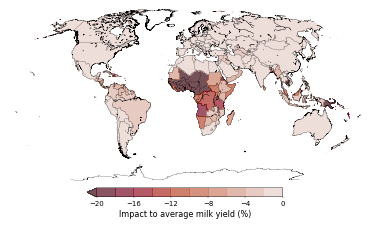

In [ ]:
colors = [rgb2hex(i) for i in px.colors.sequential.amp_r][:-1]
#colors = px.colors.sequential.Plotly3[0:-2]
levels = np.linspace(-20,0,11)
cmap, norm = flc( levels = levels, colors = colors, extend='min' )

lon2d, lat2d = np.meshgrid( lon, lat )

plt.close('all')
fig = plt.figure( figsize = ( 7, 3.5  ) )

gs = GridSpec(2, 3, height_ratios = [1, 0.05], width_ratios = [0.5, 1, 0.5] )
gs.update(wspace = 0, hspace = 0.01)

m = Basemap(projection = 'robin', lon_0 = 0, resolution = 'i', area_thresh = 1000 )
x, y = m( lon2d, lat2d )

ax1 = plt.subplot(gs[0,:])
m.drawmapboundary(fill_color = 'white', color = 'white', linewidth = 0.0)
m.contourf(x, y, out*100, levels = levels, extend = 'min', cmap = cmap, zorder=1, alpha = 0.7)
m.drawcountries( color = 'black', linewidth = 0.2 , zorder = 2)
m.drawcoastlines( color = 'black', linewidth = 0.2 , zorder = 2)

ax2 = plt.subplot( gs[1,1:2] )
CB = plt.colorbar( cax = ax2, orientation = "horizontal" )
CB.ax.tick_params( labelsize = 7 )
CB.set_label( 'Impact to average milk yield (%)', fontsize=8 )

plt.savefig('/content/drive/My Drive/figures/livestock/figure_5_map_it_cold.png', dpi = 600, bbox_inches='tight', pad_inches = 0 )

In [ ]:
regions = pd.read_excel('/content/drive/My Drive/data/econ/ssps/cmip6_iam_model_region_mapping.xlsx')
regions = regions[ ['ISO', 'Country', 'R5_region'] ]
regions= regions.replace( ['R5LAM', 'R5MAF', 'R5REF', 'R5OECD', 'R5ASIA'], ['R5.2LAM', 'R5.2MAF', 'R5.2REF', 'R5.2OECD', 'R5.2ASIA'] )
regions = regions.replace({'United States':'United States of America',
                           'Bolivia': 'Bolivia (Plurinational State of)',
                           'Libyan Arab Jamahiriya': 'Libya',
                           'Venezuela':'Venezuela (Bolivarian Republic of)',
                           'Russia':'Russian Federation',
                           'Cote dIvoire': "Côte d'Ivoire",
                           'Laos': "Lao People's Democratic Republic",
                           'Burma':'Myanmar',
                           'Korea, Democratic Peoples Republic of':"Democratic People's Republic of Korea",
                           'Korea,  Republic of': 'Republic of Korea'})

### livestock numbers from FAO ###
df = pd.read_csv( '/content/drive/My Drive/data/livestock/country_level_data/Environment_LivestockPatterns_E_All_Data_NOFLAG.csv', sep = ',', encoding = 'iso-8859-1' )
df = df.drop( columns = ['Area Code', 'Element Code', 'Item Code'] )
df = df.melt( id_vars = ['Area', 'Element', 'Item', 'Unit'], var_name = 'year', value_name = 'value' ).rename( columns = { 'Area' : 'Country' } )
df.year = df.year.apply( lambda x: x.split('Y')[1] ).astype( int )
df = df[df.Element == 'Stocks']
df = df[df.Item == 'Cattle']
df = df[df.year > 2010 ]
df = df.dropna()
dfn = df.groupby( ['Country'], as_index= False ).max()
dfn = dfn[['Country','value']].rename(columns = {'value':'number'})

### milk yield from FAO ###
df = pd.read_csv( '/content/drive/My Drive/data/livestock/country_level_data/Production_LivestockPrimary_E_All_Data_NOFLAG.csv', sep = ',', encoding = 'iso-8859-1' )
df = df.drop( columns = ['Area Code', 'Element Code', 'Item Code'] )
df = df.melt( id_vars = ['Area', 'Element', 'Item', 'Unit'], var_name = 'year', value_name = 'value' ).rename( columns = { 'Area' : 'Country' } )
df.year = df.year.apply( lambda x: x.split('Y')[1] ).astype( int )
df = df[df.Item == 'Milk, whole fresh cow']
df = df[df.Element == 'Yield']
df = pd.merge( df, regions, on = ['Country'] ).rename( columns = {'R5_region':'REGION'})
df = df[df.year < 2015 ]
df = df[df.year > 2000 ]
df = df.groupby( ['Country','ISO','REGION'], as_index= False ).mean()
df = pd.merge( df, dfn, on = ['Country'] ).rename( columns = {'value':'yield_'} )
df.yield_ = df.yield_ / 3650

## temp data, processed further below
temp = pd.read_csv('/content/drive/My Drive/data/livestock/all_models_2050.csv')
temp = temp[['produ','model', 'ssp', 'pro_h', 'ISO']]
temp = temp.dropna()
temp['change'] = (temp.produ - temp.pro_h) / 3650
temp = temp[['ssp', 'ISO', 'change']]
dft = temp.groupby(['ssp', 'ISO'], as_index=False).agg({'change': ['median','min','max']})
dft.columns = ['ssp','ISO','tmedian','tmin','tmax']

### combine with animal numbers ###
df = pd.merge(df,dft, on=['ISO'])


### get unique list of countries from FAO and GADM countries... need to rename some GADM countries to FAO designation 
dfc = pd.read_csv( '/content/drive/My Drive/data/livestock/country_level_data/Production_Livestock_E_All_Data_NOFLAG.csv', sep = ',', encoding = 'iso-8859-1' )
dfc = dfc[['Area','Item']].rename( columns = {'Area':'countryname'} )
dfc = dfc[dfc.Item == 'Cattle']
GADM =  pd.read_csv( '/content/drive/My Drive/data/area_masks/gadm36_country_names_and_abbr.csv', sep = ',' )
GADM = GADM.rename( columns = {'NAME_0':'countryname', 'GID_0': 'ISO'} )
GADM['maskid'] = GADM.index
GADM = GADM[['ISO','maskid']]
FAO =  pd.read_csv( '/content/drive/My Drive/data/area_masks/countrycodes_FAO_NAMES.csv', sep = ',' ).rename(columns = {'abb':'ISO'})
FAO = FAO[['ISO','countryname']]
countrynames = pd.merge( FAO, GADM, on = [ 'ISO' ] , how = 'inner' )

smallisland = ['Barbados','Bermuda' ,'Dominica','Bahama','Grenada','Guam','Montserrat','Malta','Nauru','Niue','Saint Kitts and Nevis', 
               'Saint Pierre and Miquelon', 'St. Vincent and the Grenadines','Singapore','Tonga','Tuvalu','Wallis and Futuna Islands']
dfc = dfc[ ~dfc.countryname.isin(smallisland) ]
dfc = pd.merge( dfc, countrynames, on = [ 'countryname' ] , how = 'inner' )
countrynames = dfc.maskid.unique()

#dfc = dfc.rename( columns = {'maskid': 'country'} ).drop( columns = ['Item'] )
dfc = dfc.drop( columns = ['countryname','Item'] )

df = df[df.ssp == 'SSP5-85']
df = pd.merge(df, dfc, on = 'ISO')

cmg  = xr.open_dataarray( '/content/drive/My Drive/data/area_masks/gadm36_countries_FOA_animal_dist_resolution.nc4' )
lat = cmg.lat.values
lon = cmg.lon.values
cmg = cmg.values

out = np.zeros_like( cmg )
for i in df.maskid.unique():
    dft = df[df.maskid == i ]
    out[cmg == i] = dft.yield_

out = np.ma.masked_where(out == 0, out)

In [ ]:
colors = [rgb2hex(i) for i in px.colors.sequential.ice_r]
#colors = px.colors.sequential.Plotly3[0:-2]
levels = np.linspace(0,22,12)
cmap, norm = flc( levels = levels, colors = colors, extend='max' )

lon2d, lat2d = np.meshgrid( lon, lat )

plt.close('all')
fig = plt.figure( figsize = ( 7, 3.5  ) )

gs = GridSpec(2, 3, height_ratios = [1, 0.05], width_ratios = [0.5, 1, 0.5] )
gs.update(wspace = 0, hspace = 0.01)

m = Basemap(projection = 'robin', lon_0 = 0, resolution = 'i', area_thresh = 1000 )
x, y = m( lon2d, lat2d )

ax1 = plt.subplot(gs[0,:])
m.drawmapboundary(fill_color = 'white', color = 'white', linewidth = 0.0)
m.contourf(x, y, out, levels = levels, extend = 'max', cmap = cmap, zorder=1, alpha = 0.7)
m.drawcountries( color = 'black', linewidth = 0.2 , zorder = 2)
m.drawcoastlines( color = 'black', linewidth = 0.2 , zorder = 2)

ax2 = plt.subplot( gs[1,1:2] )
CB = plt.colorbar( cax = ax2, orientation = "horizontal" )
CB.ax.tick_params( labelsize = 7 )
CB.set_label( 'FAO average milk yield (kg cow$^{-1}$ day$^{-1}$)', fontsize=8 )

plt.savefig('/content/drive/My Drive/figures/livestock/figure_5_map_baseline_milk_yield.png', dpi = 600, bbox_inches='tight', pad_inches = 0 )

In [ ]:
np.linspace(0,22,12)

In [ ]:
df = df[df.ssp == 'SSP5-85']
df = pd.merge(df, dfc, on = 'ISO')
df

In [ ]:
### milk yield from FAO ###
df = pd.read_csv( '/content/drive/My Drive/data/livestock/country_level_data/Production_LivestockPrimary_E_All_Data_NOFLAG.csv', sep = ',', encoding = 'iso-8859-1' )
df = df.drop( columns = ['Area Code', 'Element Code', 'Item Code'] )
df = df.melt( id_vars = ['Area', 'Element', 'Item', 'Unit'], var_name = 'year', value_name = 'value' ).rename( columns = { 'Area' : 'Country' } )
df.year = df.year.apply( lambda x: x.split('Y')[1] ).astype( int )
df = df[df.Item == 'Milk, whole fresh cow']
df = pd.merge( df, regions, on = ['Country'] ).rename( columns = {'R5_region':'REGION'})
df = df[df.year == 2015 ]
df = df[df.Unit == 'tonnes']
#df.Element.unique()
df.value.sum()

657523634.0

In [ ]:
dfp = pd.read_csv( '/content/drive/My Drive/data/livestock/country_level_data/FAOSTAT_milk_production.csv', sep = ',', encoding = 'iso-8859-1' )
dfp = dfp[['Area','Year','Unit','Value']].rename(columns = {'Area':'Country','Value':'tons'})
dfp = dfp[dfp.Unit == 'tonnes']
dfp = dfp[dfp.Year == 2015].drop(columns = ['Unit', 'Year'])


# To get dataframe for inset plots

In [ ]:
### region designations from FAO ###
regions = pd.read_excel('/content/drive/My Drive/data/econ/ssps/cmip6_iam_model_region_mapping.xlsx')
regions = regions[ ['ISO', 'Country', 'R5_region'] ]
regions= regions.replace( ['R5LAM', 'R5MAF', 'R5REF', 'R5OECD', 'R5ASIA'], ['R5.2LAM', 'R5.2MAF', 'R5.2REF', 'R5.2OECD', 'R5.2ASIA'] )
regions = regions.replace({'United States':'United States of America',
                           'Bolivia': 'Bolivia (Plurinational State of)',
                           'Libyan Arab Jamahiriya': 'Libya',
                           'Venezuela':'Venezuela (Bolivarian Republic of)',
                           'Russia':'Russian Federation',
                           'Cote dIvoire': "Côte d'Ivoire",
                           'Laos': "Lao People's Democratic Republic",
                           'Burma':'Myanmar',
                           'Korea, Democratic Peoples Republic of':"Democratic People's Republic of Korea",
                           'Korea,  Republic of': 'Republic of Korea'})

### livestock numbers from FAO ###
df = pd.read_csv( '/content/drive/My Drive/data/livestock/country_level_data/Environment_LivestockPatterns_E_All_Data_NOFLAG.csv', sep = ',', encoding = 'iso-8859-1' )
df = df.drop( columns = ['Area Code', 'Element Code', 'Item Code'] )
df = df.melt( id_vars = ['Area', 'Element', 'Item', 'Unit'], var_name = 'year', value_name = 'value' ).rename( columns = { 'Area' : 'Country' } )
df.year = df.year.apply( lambda x: x.split('Y')[1] ).astype( int )
df = df[df.Element == 'Stocks']
df = df[df.Item == 'Cattle']
df = df[df.year > 2010 ]
df = df.dropna()
dfn = df.groupby( ['Country'], as_index= False ).max()
dfn = dfn[['Country','value']].rename(columns = {'value':'number'})

### milk yield from FAO ###
df = pd.read_csv( '/content/drive/My Drive/data/livestock/country_level_data/Production_LivestockPrimary_E_All_Data_NOFLAG.csv', sep = ',', encoding = 'iso-8859-1' )
df = df.drop( columns = ['Area Code', 'Element Code', 'Item Code'] )
df = df.melt( id_vars = ['Area', 'Element', 'Item', 'Unit'], var_name = 'year', value_name = 'value' ).rename( columns = { 'Area' : 'Country' } )
df.year = df.year.apply( lambda x: x.split('Y')[1] ).astype( int )
df = df[df.Item == 'Milk, whole fresh cow']
dfy = df[df.Element == 'Yield']
dfy = pd.merge( dfy, regions, on = ['Country'] ).rename( columns = {'R5_region':'REGION'})
dfy = dfy[dfy.year < 2015 ]
dfy = dfy[dfy.year > 2000 ]
dfy = dfy.groupby( ['Country','ISO','REGION'], as_index= False ).mean()
dfy = pd.merge( dfy, dfn, on = ['Country'] ).rename( columns = {'value':'yield_'} )
dfy.yield_ = dfy.yield_ / 3650

df = df[df.Element == 'Production']
df = df[df.year < 2015 ]
df = df[df.year > 2000 ]
df = df.groupby( ['Country'], as_index= False ).mean().rename( columns = {'value':'prod_'} )
df = df[['Country','prod_']]
df = pd.merge( dfy, df, on = ['Country'] )

## temp data, processed further below
temp = pd.read_csv('/content/drive/My Drive/data/livestock/all_models_2050.csv')
temp = temp[['produ','model', 'ssp', 'pro_h', 'ISO']]
temp = temp.dropna()
temp['change'] = (temp.produ - temp.pro_h) / 3650
temp = temp[['ssp', 'ISO', 'change']]
dft = temp.groupby(['ssp', 'ISO'], as_index=False).agg({'change': ['median','min','max']})
dft.columns = ['ssp','ISO','tmedian','tmin','tmax']

### combine with animal numbers ###
df = pd.merge( df, dft, on = ['ISO'] )

## Get separate indicine and taurine dataframes
east_africa = ['United Republic of Tanzania', 'Kenya', 'Uganda', 'Rwanda', 'Burundi','Sudan','South Sudan','Djibouti', 'Eritrea', 'Ethiopia', 
               'Somalia', 'Comoros', 'Mauritius', 'Seychelles', 'Mozambique', 'Madagascar','Malawi', 'Zambia', 'Zimbabwe']
north_africa = ['Algeria','Egypt','Morocco','Libya','Tunisia']
mid_east = ['United Arab Emirates','Yemen','Saudi Arabia','Oman', 'Qatar','Iran (Islamic Republic of)', 'Iraq', 'Israel', 'Jordan','Kuwait', 'Lebanon']
maf_taur = east_africa + north_africa + mid_east

dfi = df[df.REGION.isin(['R5.2ASIA','R5.2LAM'])]
dfi = dfi[~dfi.Country.isin(['China','Mongolia','Republic of Korea',"Democratic People's Republic of Korea",'Mexico'])]
dfi2 = df[df.Country.isin( maf_taur )]
dfi = pd.concat( [dfi, dfi2] )
dfi['kind'] = 'indicine'

dft = df[ df.REGION.isin(['R5.2OECD','R5.2MAF','R5.2REF']) ]
dft = dft[ ~dft.Country.isin( maf_taur ) ]
dft2 = df[ df.Country.isin(['China','Mongolia','Republic of Korea',"Democratic People's Republic of Korea", 'Mexico']) ]
dft = pd.concat( [dft, dft2] )
dft['kind'] = 'taurine'

### calc the deltas ###
dfi['minmin'] = dfi.tmin * -0.015
dfi['minmed'] = dfi.tmin * -0.051
dfi['minmax'] = dfi.tmin * -0.087

dfi['medmin'] = dfi.tmedian * -0.015
dfi['medmed'] = dfi.tmedian * -0.051
dfi['medmax'] = dfi.tmedian * -0.087

dfi['maxmin'] = dfi.tmax * -0.015
dfi['maxmed'] = dfi.tmax * -0.51
dfi['maxmax'] = dfi.tmax * -0.087

### calc the deltas ###
dft['minmin'] = dft.tmin * -0.07
dft['minmed'] = dft.tmin * -0.15
dft['minmax'] = dft.tmin * -0.24

dft['medmin'] = dft.tmedian * -0.07
dft['medmed'] = dft.tmedian * -0.15
dft['medmax'] = dft.tmedian * -0.24

dft['maxmin'] = dft.tmax * -0.07
dft['maxmed'] = dft.tmax * -0.15
dft['maxmax'] = dft.tmax * -0.24

df = pd.concat([dfi,dft])

df['per_change'] = df.medmed / df.yield_
df['per_change1'] = df.medmax / df.yield_
df['per_change2'] = df.medmin / df.yield_
df['per_change3'] = df.maxmed / df.yield_
df['per_change4'] = df.minmed / df.yield_
df = df[ ['Country','ISO','REGION','ssp','per_change','per_change1','per_change2','per_change3','per_change4']]

dfp = pd.read_csv( '/content/drive/My Drive/data/livestock/country_level_data/FAOSTAT_milk_production.csv', sep = ',', encoding = 'iso-8859-1' )
dfp = dfp[['Area','Year','Unit','Value']].rename(columns = {'Area':'Country','Value':'tons'})
dfp = dfp[dfp.Unit == 'tonnes']
dfp = dfp[dfp.Year == 2015].drop( columns = ['Unit', 'Year'] )

df = pd.merge(df, dfp, on = 'Country')
df['ton_loss'] = df.per_change * df.tons
df['ton_loss1'] = df.per_change1 * df.tons
df['ton_loss2'] = df.per_change2 * df.tons
df['ton_loss3'] = df.per_change3 * df.tons
df['ton_loss4'] = df.per_change4 * df.tons
df = df.groupby(['REGION','ssp'], as_index= False).sum()
#df = df.sort_values(by='ton_loss', ascending=False)
df = df[df.ssp.isin(['SSP5-85', 'SSP1-26'])]
df

,REGION,ssp,per_change,per_change1,per_change2,per_change3,per_change4,tons,ton_loss,ton_loss1,ton_loss2,ton_loss3,ton_loss4
0,R5.2ASIA,SSP1-26,-1.100383,-1.874221,-0.328374,-16.899623,-0.694307,132107050.0,-2.167073e+06,-3.658707e+06,-6.994075e+05,-2.993950e+07,-1.554590e+06
3,R5.2ASIA,SSP5-85,-1.698086,-2.891708,-0.507631,-26.381949,-1.116343,132107050.0,-3.292140e+06,-5.558210e+06,-1.062460e+06,-4.546265e+07,-2.386513e+06
4,R5.2LAM,SSP1-26,-0.812432,-1.384904,-0.240597,-13.173534,-0.506723,81174894.0,-1.289667e+06,-2.188508e+06,-3.980734e+05,-1.781737e+07,-9.058899e+05
7,R5.2LAM,SSP5-85,-1.263472,-2.153633,-0.374382,-18.901530,-0.881899,81174894.0,-2.024924e+06,-3.434898e+06,-6.271554e+05,-2.868537e+07,-1.512936e+06
8,R5.2MAF,SSP1-26,-6.989081,-11.317606,-3.041446,-29.620375,-4.509209,47885775.0,-2.280404e+06,-3.775911e+06,-8.567932e+05,-2.102665e+07,-1.483322e+06
11,R5.2MAF,SSP5-85,-10.532080,-17.062014,-4.571631,-46.076032,-6.345199,47885775.0,-3.523264e+06,-5.837274e+06,-1.318178e+06,-3.385647e+07,-2.203847e+06
12,R5.2OECD,SSP1-26,-0.175169,-0.280271,-0.081746,-0.328574,-0.075938,311132598.0,-7.829984e+05,-1.252797e+06,-3.653993e+05,-1.575250e+06,-3.810217e+05
15,R5.2OECD,SSP5-85,-0.271546,-0.434473,-0.126721,-0.494206,-0.159924,311132598.0,-1.248908e+06,-1.998253e+06,-5.828237e+05,-2.556213e+06,-7.621936e+05
16,R5.2REF,SSP1-26,-0.099665,-0.159464,-0.046510,-0.166425,-0.053759,70082966.0,-3.777769e+05,-6.044431e+05,-1.762959e+05,-6.826019e+05,-2.072997e+05
19,R5.2REF,SSP5-85,-0.168700,-0.269920,-0.078727,-0.302797,-0.111427,70082966.0,-6.306836e+05,-1.009094e+06,-2.943190e+05,-1.214838e+06,-4.607008e+05


In [ ]:
-3292140.3435238837	/132107050.0

-0.024920247205004454

In [ ]:
x = -782998.3976652863 -2280403.8717055162	-1289666.5709615648	-2167073.431619104
x/1e6

-6.520142271951472

In [ ]:
### region designations from FAO ###
regions = pd.read_excel('/content/drive/My Drive/data/econ/ssps/cmip6_iam_model_region_mapping.xlsx')
regions = regions[ ['ISO', 'Country', 'R5_region'] ]
regions= regions.replace( ['R5LAM', 'R5MAF', 'R5REF', 'R5OECD', 'R5ASIA'], ['R5.2LAM', 'R5.2MAF', 'R5.2REF', 'R5.2OECD', 'R5.2ASIA'] )
regions = regions.replace({'United States':'United States of America',
                           'Bolivia': 'Bolivia (Plurinational State of)',
                           'Libyan Arab Jamahiriya': 'Libya',
                           'Venezuela':'Venezuela (Bolivarian Republic of)',
                           'Russia':'Russian Federation',
                           'Cote dIvoire': "Côte d'Ivoire",
                           'Laos': "Lao People's Democratic Republic",
                           'Burma':'Myanmar',
                           'Korea, Democratic Peoples Republic of':"Democratic People's Republic of Korea",
                           'Korea,  Republic of': 'Republic of Korea'})

### livestock numbers from FAO ###
df = pd.read_csv( '/content/drive/My Drive/data/livestock/country_level_data/Environment_LivestockPatterns_E_All_Data_NOFLAG.csv', sep = ',', encoding = 'iso-8859-1' )
df = df.drop( columns = ['Area Code', 'Element Code', 'Item Code'] )
df = df.melt( id_vars = ['Area', 'Element', 'Item', 'Unit'], var_name = 'year', value_name = 'value' ).rename( columns = { 'Area' : 'Country' } )
df.year = df.year.apply( lambda x: x.split('Y')[1] ).astype( int )
df = df[df.Element == 'Stocks']
df = df[df.Item == 'Cattle']
df = df[df.year > 2010 ]
df = df.dropna()
dfn = df.groupby( ['Country'], as_index= False ).max()
dfn = dfn[['Country','value']].rename(columns = {'value':'number'})

### milk yield from FAO ###
df = pd.read_csv( '/content/drive/My Drive/data/livestock/country_level_data/Production_LivestockPrimary_E_All_Data_NOFLAG.csv', sep = ',', encoding = 'iso-8859-1' )
df = df.drop( columns = ['Area Code', 'Element Code', 'Item Code'] )
df = df.melt( id_vars = ['Area', 'Element', 'Item', 'Unit'], var_name = 'year', value_name = 'value' ).rename( columns = { 'Area' : 'Country' } )
df.year = df.year.apply( lambda x: x.split('Y')[1] ).astype( int )
df = df[df.Item == 'Milk, whole fresh cow']
dfy = df[df.Element == 'Yield']
dfy = pd.merge( dfy, regions, on = ['Country'] ).rename( columns = {'R5_region':'REGION'})
dfy = dfy[dfy.year < 2015 ]
dfy = dfy[dfy.year > 2000 ]
dfy = dfy.groupby( ['Country','ISO','REGION'], as_index= False ).mean()
dfy = pd.merge( dfy, dfn, on = ['Country'] ).rename( columns = {'value':'yield_'} )
dfy.yield_ = dfy.yield_ / 3650

df = df[df.Element == 'Production']
df = df[df.year < 2015 ]
df = df[df.year > 2000 ]
df = df.groupby( ['Country'], as_index= False ).mean().rename( columns = {'value':'prod_'} )
df = df[['Country','prod_']]
df = pd.merge( dfy, df, on = ['Country'] )

## temp data, processed further below
temp = pd.read_csv('/content/drive/My Drive/data/livestock/all_models_2050_cold.csv')
temp = temp[['produ','model', 'ssp', 'pro_h', 'ISO']]
temp = temp.dropna()
temp['change'] = (temp.produ - temp.pro_h) / 3650
temp = temp[['ssp', 'ISO', 'change']]
dft = temp.groupby(['ssp', 'ISO'], as_index=False).agg({'change': ['median','min','max']})
dft.columns = ['ssp','ISO','tmedian','tmin','tmax']

### combine with animal numbers ###
df = pd.merge( df, dft, on = ['ISO'] )

## Get separate indicine and taurine dataframes
east_africa = ['United Republic of Tanzania', 'Kenya', 'Uganda', 'Rwanda', 'Burundi','Sudan','South Sudan','Djibouti', 'Eritrea', 'Ethiopia', 
               'Somalia', 'Comoros', 'Mauritius', 'Seychelles', 'Mozambique', 'Madagascar','Malawi', 'Zambia', 'Zimbabwe']
north_africa = ['Algeria','Egypt','Morocco','Libya','Tunisia']
mid_east = ['United Arab Emirates','Yemen','Saudi Arabia','Oman', 'Qatar','Iran (Islamic Republic of)', 'Iraq', 'Israel', 'Jordan','Kuwait', 'Lebanon']
maf_taur = east_africa + north_africa + mid_east

dfi = df[df.REGION.isin(['R5.2ASIA','R5.2LAM'])]
dfi = dfi[~dfi.Country.isin(['China','Mongolia','Republic of Korea',"Democratic People's Republic of Korea",'Mexico'])]
dfi2 = df[df.Country.isin( maf_taur )]
dfi = pd.concat( [dfi, dfi2] )
dfi['kind'] = 'indicine'

dft = df[ df.REGION.isin(['R5.2OECD','R5.2MAF','R5.2REF']) ]
dft = dft[ ~dft.Country.isin( maf_taur ) ]
dft2 = df[ df.Country.isin(['China','Mongolia','Republic of Korea',"Democratic People's Republic of Korea", 'Mexico']) ]
dft = pd.concat( [dft, dft2] )
dft['kind'] = 'taurine'

### calc the deltas ###
dfi['minmin'] = dfi.tmin * -0.015
dfi['minmed'] = dfi.tmin * -0.051
dfi['minmax'] = dfi.tmin * -0.087

dfi['medmin'] = dfi.tmedian * -0.015
dfi['medmed'] = dfi.tmedian * -0.051
dfi['medmax'] = dfi.tmedian * -0.087

dfi['maxmin'] = dfi.tmax * -0.015
dfi['maxmed'] = dfi.tmax * -0.51
dfi['maxmax'] = dfi.tmax * -0.087

### calc the deltas ###
dft['minmin'] = dft.tmin * -0.07
dft['minmed'] = dft.tmin * -0.15
dft['minmax'] = dft.tmin * -0.24

dft['medmin'] = dft.tmedian * -0.07
dft['medmed'] = dft.tmedian * -0.15
dft['medmax'] = dft.tmedian * -0.24

dft['maxmin'] = dft.tmax * -0.07
dft['maxmed'] = dft.tmax * -0.15
dft['maxmax'] = dft.tmax * -0.24

df = pd.concat([dfi,dft])

df['per_change'] = df.medmed / df.yield_
df['per_change1'] = df.medmax / df.yield_
df['per_change2'] = df.medmin / df.yield_
df['per_change3'] = df.maxmed / df.yield_
df['per_change4'] = df.minmed / df.yield_
df = df[ ['Country','ISO','REGION','ssp','per_change','per_change1','per_change2','per_change3','per_change4']]

dfp = pd.read_csv( '/content/drive/My Drive/data/livestock/country_level_data/FAOSTAT_milk_production.csv', sep = ',', encoding = 'iso-8859-1' )
dfp = dfp[['Area','Year','Unit','Value']].rename(columns = {'Area':'Country','Value':'tons'})
dfp = dfp[dfp.Unit == 'tonnes']
dfp = dfp[dfp.Year == 2015].drop( columns = ['Unit', 'Year'] )

df = pd.merge(df, dfp, on = 'Country')
df['ton_loss'] = df.per_change * df.tons
df['ton_loss1'] = df.per_change1 * df.tons
df['ton_loss2'] = df.per_change2 * df.tons
df['ton_loss3'] = df.per_change3 * df.tons
df['ton_loss4'] = df.per_change4 * df.tons
df = df.groupby(['REGION','ssp'], as_index= False).sum()
#df = df.sort_values(by='ton_loss', ascending=False)
#df = df[df.ssp == 'SSP5-85']
df

,REGION,ssp,per_change,per_change1,per_change2,per_change3,per_change4,tons,ton_loss,ton_loss1,ton_loss2,ton_loss3,ton_loss4
0,R5.2ASIA,SSP1-26,-0.847978,-1.445474,-0.251158,-12.964861,-0.341574,132107017.0,-1.115032e+06,-1.900082e+06,-3.312624e+05,-1.537505e+07,-5.843390e+05
1,R5.2ASIA,SSP5-85,-1.454722,-2.479906,-0.430596,-21.306397,-0.810931,132107017.0,-1.836898e+06,-3.130127e+06,-5.458138e+05,-2.671175e+07,-1.238689e+06
2,R5.2LAM,SSP1-26,-0.512321,-0.873581,-0.151298,-8.364049,-0.240012,81169751.0,-8.862395e+05,-1.507517e+06,-2.676714e+05,-1.460624e+07,-3.404184e+05
3,R5.2LAM,SSP5-85,-0.869319,-1.482175,-0.256956,-12.242778,-0.545851,81169751.0,-1.601425e+06,-2.722938e+06,-4.855186e+05,-2.254694e+07,-9.194870e+05
4,R5.2MAF,SSP1-26,-4.995134,-8.089048,-2.173260,-22.500324,-2.392300,47872075.0,-1.572360e+06,-2.604487e+06,-5.892007e+05,-1.631535e+07,-7.587425e+05
5,R5.2MAF,SSP5-85,-8.597489,-13.938074,-3.715420,-37.297980,-4.623463,47872075.0,-2.911260e+06,-4.829560e+06,-1.079036e+06,-2.724007e+07,-1.657143e+06
6,R5.2OECD,SSP1-26,-0.092359,-0.147775,-0.043101,-0.210648,-0.020313,311130363.0,-2.655129e+05,-4.248207e+05,-1.239060e+05,-7.451407e+05,-4.512191e+04
7,R5.2OECD,SSP5-85,-0.149039,-0.238462,-0.069551,-0.330675,-0.072016,311130363.0,-4.840259e+05,-7.744415e+05,-2.258788e+05,-1.216156e+06,-2.162318e+05
8,R5.2REF,SSP1-26,-0.057357,-0.091771,-0.026766,-0.109559,-0.023700,70082966.0,-2.283142e+05,-3.653027e+05,-1.065466e+05,-4.462045e+05,-9.792568e+04
9,R5.2REF,SSP5-85,-0.106452,-0.170324,-0.049678,-0.203975,-0.061447,70082966.0,-4.069085e+05,-6.510535e+05,-1.898906e+05,-7.632875e+05,-2.583876e+05


In [4]:
print( 'oecd:', (0.27 -0.15) / 0.27)
print( 'maf:', (10.5-8.6) / 10.5)
print( 'lam:', (1.26-0.87) / 1.26)
print( 'asia:', (1.69-1.45) / 1.69)

oecd: 0.4444444444444445
maf: 0.18095238095238098
lam: 0.30952380952380953
asia: 0.14201183431952663


In [6]:
200+300+100+200 


800

In [7]:
500+200+400+500

1600

In [ ]:
OECD = -0.15 - 0.27
MAF = -8.6 %
LAM = -0.87 %
ASIA = -1.45 %

In [ ]:
OECD = -484025
MAF  = -2911260
LAM  = -1601425
ASIA = -1836898

In [ ]:
x = -265512.948087565 -1572359.674459124 -886239.5149993921 -886239.5149993921
x/1e6

-3.610351652545473

-26711752.634722818
-15375054.21984196
-22546936.546850674
-14606238.423735907
-27240069.565524716
-16315348.610008169


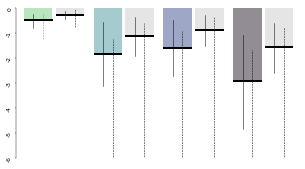

In [ ]:
regions = [ 'R5.2OECD', 'R5.2ASIA', 'R5.2LAM', 'R5.2MAF']
colors = [rgb2hex(i) for i in px.colors.sequential.deep[2::3]]

plt.rcParams.update( {'font.size': 8, 'xtick.labelsize' : 6, 'ytick.labelsize' : 6, 'legend.fontsize': 6, 'legend.frameon': False, 
                    'axes.linewidth':0.4, 'xtick.major.width':0.4, 'ytick.major.width':0.4, 'xtick.major.size':1, 'ytick.major.size':1,
                    'xtick.bottom': True, 'xtick.top': False, 'ytick.right': False, 'ytick.right': False, 'legend.numpoints': 4,
                    'xtick.major.pad':3, 'ytick.major.pad':3, 'axes.labelpad':3,'xtick.direction': 'out', 'ytick.direction': 'out', 
                    'axes.edgecolor':'black','ytick.color':'black','xtick.color':'black','axes.facecolor':'white'} )

plt.close('all')
fig = plt.figure( figsize = ( 5, 2.75 ) )

gs = GridSpec(1, 4 )
gs.update(wspace = 0.0, hspace = 0.0)

ax1 = plt.subplot(gs[0,0])
dft = df[df.REGION == 'R5.2OECD']
dft1 = dft[dft.ssp == 'SSP5-85']
size = dft1.ton_loss.values[0]
plt.bar( 1, size, facecolor = colors[0], alpha = 0.7, edgecolor = 'none', width = 0.9 )
plt.plot(  np.array([0.58, 1.42]), np.array([size, size]), color = 'black', zorder = 5, lw = 2 )
high = dft1.ton_loss1.values[0]
low = dft1.ton_loss2.values[0]
plt.errorbar( np.array([0.85,0.85]), [high,low], color = 'black', lw = 0.5)
high = dft1.ton_loss3.values[0]
low = dft1.ton_loss4.values[0]
plt.errorbar( np.array([1.15,1.15]), [high,low], color = 'gray', lw = 0.5, linestyle ='--')
dft1 = dft[dft.ssp == 'SSP1-26']
size = dft1.ton_loss.values[0]
plt.bar( 2, size, facecolor = 'gray', alpha = 0.2, edgecolor = 'none', width = 0.9 )
plt.plot(  np.array([1.58, 2.42]), np.array([size, size]), color = 'black', zorder = 5, lw = 2 )
high = dft1.ton_loss1.values[0]
low = dft1.ton_loss2.values[0]
plt.errorbar( np.array([1.85,1.85]), [high,low], color = 'black', lw = 0.5)
high = dft1.ton_loss3.values[0]
low = dft1.ton_loss4.values[0]
plt.errorbar( np.array([2.15,2.15]), [high,low], color = 'black', lw = 0.5, linestyle ='--')

ymin = -6e6
plt.ylim(ymin,0)
plt.yticks([-6e6,-5e6,-4e6,-3e6,-2e6,-1e6,0],[-6,-5,-4,-3,-2,-1,0])
plt.xlim(0.4,2.6)
plt.xticks([],[])
ax1.spines['bottom'].set_color('white')
sns.despine( offset = 3, trim = True )
plt.yticks( rotation = 90, va = 'center' )

ax1 = plt.subplot(gs[0,1])
dft = df[df.REGION == 'R5.2ASIA']
dft1 = dft[dft.ssp == 'SSP5-85']
size = dft1.ton_loss.values[0]
plt.bar( 1, size, facecolor = colors[1], alpha = 0.5, edgecolor = 'none', width = 0.9 )
plt.plot(  np.array([0.58, 1.42]), np.array([size, size]), color = 'black', zorder = 5, lw = 2 )
high = dft1.ton_loss1.values[0]
low = dft1.ton_loss2.values[0]
plt.errorbar( np.array([0.85,0.85]), [high,low], color = 'black', lw = 0.5)
high = dft1.ton_loss3.values[0]
low = dft1.ton_loss4.values[0]
print(high)
plt.errorbar( np.array([1.15,1.15]), [high,low], color = 'black', lw = 0.5, linestyle ='--')
dft1 = dft[dft.ssp == 'SSP1-26']
size = dft1.ton_loss.values[0]
plt.bar( 2, size, facecolor = 'gray', alpha = 0.2, edgecolor = 'none', width = 0.9 )
plt.plot(  np.array([1.58, 2.42]), np.array([size, size]), color = 'black', zorder = 5, lw = 2 )
high = dft1.ton_loss1.values[0]
low = dft1.ton_loss2.values[0]
plt.errorbar( np.array([1.85,1.85]), [high,low], color = 'black', lw = 0.5)
high = dft1.ton_loss3.values[0]
low = dft1.ton_loss4.values[0]
print(high)
plt.errorbar( np.array([2.15,2.15]), [high,low], color = 'black', lw = 0.5, linestyle ='--')

plt.ylim(ymin,0)
plt.xlim(0.4,2.6)
plt.axis('off')

ax1 = plt.subplot(gs[0,2])
dft = df[df.REGION == 'R5.2LAM']
dft1 = dft[dft.ssp == 'SSP5-85']
size = dft1.ton_loss.values[0]
plt.bar( 1, size, facecolor = colors[2], alpha = 0.5, edgecolor = 'none', width = 0.9 )
plt.plot(  np.array([0.58, 1.42]), np.array([size, size]), color = 'black', zorder = 5, lw = 2 )
high = dft1.ton_loss1.values[0]
low = dft1.ton_loss2.values[0]
plt.errorbar( np.array([0.85,0.85]), [high,low], color = 'black', lw = 0.5)
high = dft1.ton_loss3.values[0]
low = dft1.ton_loss4.values[0]
print(high)
plt.errorbar( np.array([1.15,1.15]), [high,low], color = 'black', lw = 0.5, linestyle ='--')
dft1 = dft[dft.ssp == 'SSP1-26']
size = dft1.ton_loss.values[0]
plt.bar( 2, size, facecolor = 'gray', alpha = 0.2, edgecolor = 'none', width = 0.9 )
plt.plot(  np.array([1.58, 2.42]), np.array([size, size]), color = 'black', zorder = 5, lw = 2 )
high = dft1.ton_loss1.values[0]
low = dft1.ton_loss2.values[0]
plt.errorbar( np.array([1.85,1.85]), [high,low], color = 'black', lw = 0.5)
high = dft1.ton_loss3.values[0]
low = dft1.ton_loss4.values[0]
print(high)
plt.errorbar( np.array([2.15,2.15]), [high,low], color = 'black', lw = 0.5, linestyle ='--')
plt.ylim(ymin,0)
plt.xlim(0.4,2.6)
plt.axis('off')

ax1 = plt.subplot(gs[0,3])
dft = df[df.REGION == 'R5.2MAF']
dft1 = dft[dft.ssp == 'SSP5-85']
size = dft1.ton_loss.values[0]
plt.bar( 1, size, facecolor = colors[3], alpha = 0.5, edgecolor = 'none', width = 0.9 )
plt.plot(  np.array([0.58, 1.42]), np.array([size, size]), color = 'black', zorder = 5, lw = 2 )
high = dft1.ton_loss1.values[0]
low = dft1.ton_loss2.values[0]
plt.errorbar( np.array([0.85,0.85]), [high,low], color = 'black', lw = 0.5)
high = dft1.ton_loss3.values[0]
low = dft1.ton_loss4.values[0]
print(high)
plt.errorbar( np.array([1.15,1.15]), [high,low], color = 'black', lw = 0.5, linestyle ='--')
dft1 = dft[dft.ssp == 'SSP1-26']
size = dft1.ton_loss.values[0]
plt.bar( 2, size, facecolor = 'gray', alpha = 0.2, edgecolor = 'none', width = 0.9 )
plt.plot(  np.array([1.58, 2.42]), np.array([size, size]), color = 'black', zorder = 5, lw = 2 )
high = dft1.ton_loss1.values[0]
low = dft1.ton_loss2.values[0]
plt.errorbar( np.array([1.85,1.85]), [high,low], color = 'black', lw = 0.5)
high = dft1.ton_loss3.values[0]
low = dft1.ton_loss4.values[0]
print(high)
plt.errorbar( np.array([2.15,2.15]), [high,low], color = 'black', lw = 0.5, linestyle ='--')

plt.ylim(ymin,0)
plt.xlim(0.4,2.6)
plt.axis('off')

plt.savefig( f'/content/drive/My Drive/figures/livestock/figure5_panle_b_cold.png', dpi = 700, bbox_inches = 'tight', pad_inches = 0.00 )


In [ ]:
-1.914992289795232 -13.222248069863939 -8.587093969452306 -11.02603699049944

In [ ]:
-1.2005975430867724 -8.703007782538627-5.4925378866114105 -7.074186974967484

In [ ]:
regions = [ 'R5.2OECD', 'R5.2ASIA', 'R5.2LAM', 'R5.2MAF']
colors = [rgb2hex(i) for i in px.colors.sequential.deep[1::3]]

plt.rcParams.update( {'font.size': 8, 'xtick.labelsize' : 6, 'ytick.labelsize' : 6, 'legend.fontsize': 6, 'legend.frameon': False, 
                    'axes.linewidth':0.4, 'xtick.major.width':0.4, 'ytick.major.width':0.4, 'xtick.major.size':1, 'ytick.major.size':1,
                    'xtick.bottom': True, 'xtick.top': False, 'ytick.right': False, 'ytick.right': False, 'legend.numpoints': 4,
                    'xtick.major.pad':3, 'ytick.major.pad':3, 'axes.labelpad':3,'xtick.direction': 'out', 'ytick.direction': 'out', 
                    'axes.edgecolor':'black','ytick.color':'black','xtick.color':'black','axes.facecolor':'white'} )

plt.close('all')
fig = plt.figure( figsize = ( 7, 2 ) )

gs = GridSpec(1, 4 )
gs.update(wspace = 0.0, hspace = 0.0)

for i, region in enumerate(regions):
    plt.close('all')
    dft = df[df.REGION == region]
    fig = plt.figure( figsize = (5, 5 ) )

    dft1 = dft[dft.ssp == 'SSP5-85']
    size = np.abs(dft1.ton_loss)/1e6
    plt.bar( 1, size, facecolor = colors[i], alpha = 0.5, edgecolor = 'none' )
    dft1 = dft[dft.ssp == 'SSP3-70']
    size = np.abs(dft1.ton_loss)/1e6
    plt.bar( 2, size, facecolor = colors[i], alpha = 0.5, edgecolor = 'none' )
    dft1 = dft[dft.ssp == 'SSP2-45']
    size = np.abs(dft1.ton_loss)/1e6
    plt.bar( 3, size, facecolor = colors[i], alpha = 0.5, edgecolor = 'none' )
    dft1 = dft[dft.ssp == 'SSP1-26']
    size = np.abs(dft1.ton_loss)/1e6
    plt.bar( 4, size, facecolor = colors[i], alpha = 0.5, edgecolor = 'none' )

    plt.ylim(0,21)
    plt.xlim(0.5,4.5)

    plt.savefig( f'/content/drive/My Drive/figures/livestock/bubble_{region}.png', dpi = 700, bbox_inches = 'tight', pad_inches = 0.00, transparent = True )


In [ ]:
regions = [ 'R5.2OECD', 'R5.2ASIA', 'R5.2LAM', 'R5.2MAF']
colors = [rgb2hex(i) for i in px.colors.sequential.deep[1::3]]

for i, region in enumerate(regions):
    plt.close('all')
    dft = df[df.REGION == region]
    fig = plt.figure( figsize = (4.6, 4.6 ) )
    ax = fig.gca()

    dft1 = dft[dft.ssp == 'SSP5-85']
    size = np.sqrt(np.abs(dft1.ton_loss))/1000
    rect1 = Rectangle((0,0), size, size, facecolor = colors[i], alpha = 0.4, edgecolor = 'black', lw = 0.1 )
    
    dft1 = dft[dft.ssp == 'SSP3-70']
    size = np.sqrt(np.abs(dft1.ton_loss))/1000
    rect2 = Rectangle((0,0), size, size, facecolor = colors[i], alpha = 0.4, edgecolor = 'black', lw = 0.1 )
    
    dft1 = dft[dft.ssp == 'SSP2-45']
    size = np.sqrt(np.abs(dft1.ton_loss))/1000
    rect3 = Rectangle((0,0), size, size, facecolor = colors[i], alpha = 0.4, edgecolor = 'black', lw = 0.1 )
    
    dft1 = dft[dft.ssp == 'SSP1-26']
    size = np.sqrt(np.abs(dft1.ton_loss))/1000
    rect4 = Rectangle((0,0), size, size, facecolor = colors[i], alpha = 0.4, edgecolor = 'black', lw = 0.1 )

    ax.add_artist(rect1)
    ax.add_artist(rect2)
    ax.add_artist(rect3)
    ax.add_artist(rect4)

    plt.xlim(0,4.7)
    plt.ylim(0,4.7)

    plt.axis('off')
    plt.savefig( f'/content/drive/My Drive/figures/livestock/bubble_{region}.png', dpi = 700, bbox_inches = 'tight', pad_inches = 0.00, transparent = True )


In [ ]:
np.sqrt(10765542)

In [ ]:
factor = 3.7420358856706175e-05
colors = [rgb2hex(i) for i in px.colors.sequential.deep[1::3]]
plt.close('all')
for region in regions:
    dft = d
fig = plt.figure( figsize = (0.65, 0.65 ) )
plt.scatter(0, 0, s=dft.q   , alpha=0.5, facecolor = colors[0], edgecolors='none')
plt.scatter(0, 0, s=129, alpha=0.5, facecolor = 'none', edgecolors='black', lw = 0.2, zorder = 10)
plt.scatter(0, 0, s=159, alpha=0.5, facecolor = 'none', edgecolors='black', lw = 0.2, zorder = 10)
plt.scatter(0, 0, s=167, alpha=0.5, facecolor = 'none', edgecolors='black', lw = 0.2, zorder = 10)
plt.scatter(0, 0, s=200, alpha=0.5, facecolor = 'none', edgecolors='black', lw = 0.2, zorder = 10)
plt.axis('off')
plt.savefig( f'/content/drive/My Drive/figures/livestock/bubble_{region}.png', dpi = 1000, bbox_inches = 'tight', pad_inches = 0.00, transparent = True)

In [ ]:
### region designations from FAO ###
regions = pd.read_excel('/content/drive/My Drive/data/econ/ssps/cmip6_iam_model_region_mapping.xlsx')
regions = regions[ ['ISO', 'Country', 'R5_region'] ]
regions= regions.replace( ['R5LAM', 'R5MAF', 'R5REF', 'R5OECD', 'R5ASIA'], ['R5.2LAM', 'R5.2MAF', 'R5.2REF', 'R5.2OECD', 'R5.2ASIA'] )
regions = regions.replace({'United States':'United States of America',
                           'Bolivia': 'Bolivia (Plurinational State of)',
                           'Libyan Arab Jamahiriya': 'Libya',
                           'Venezuela':'Venezuela (Bolivarian Republic of)',
                           'Russia':'Russian Federation',
                           'Cote dIvoire': "Côte d'Ivoire",
                           'Laos': "Lao People's Democratic Republic",
                           'Burma':'Myanmar',
                           'Korea, Democratic Peoples Republic of':"Democratic People's Republic of Korea",
                           'Korea,  Republic of': 'Republic of Korea'})

### livestock numbers from FAO ###
df = pd.read_csv( '/content/drive/My Drive/data/livestock/country_level_data/Environment_LivestockPatterns_E_All_Data_NOFLAG.csv', sep = ',', encoding = 'iso-8859-1' )
df = df.drop( columns = ['Area Code', 'Element Code', 'Item Code'] )
df = df.melt( id_vars = ['Area', 'Element', 'Item', 'Unit'], var_name = 'year', value_name = 'value' ).rename( columns = { 'Area' : 'Country' } )
df.year = df.year.apply( lambda x: x.split('Y')[1] ).astype( int )
df = df[df.Element == 'Stocks']
df = df[df.Item == 'Cattle']
df = df[df.year > 2010 ]
df = df.dropna()
dfn = df.groupby( ['Country'], as_index= False ).max()
dfn = dfn[['Country','value']].rename(columns = {'value':'number'})

### milk yield from FAO ###
df = pd.read_csv( '/content/drive/My Drive/data/livestock/country_level_data/Production_LivestockPrimary_E_All_Data_NOFLAG.csv', sep = ',', encoding = 'iso-8859-1' )
df = df.drop( columns = ['Area Code', 'Element Code', 'Item Code'] )
df = df.melt( id_vars = ['Area', 'Element', 'Item', 'Unit'], var_name = 'year', value_name = 'value' ).rename( columns = { 'Area' : 'Country' } )
df.year = df.year.apply( lambda x: x.split('Y')[1] ).astype( int )
df = df[df.Item == 'Milk, whole fresh cow']
dfy = df[df.Element == 'Yield']
dfy = pd.merge( dfy, regions, on = ['Country'] ).rename( columns = {'R5_region':'REGION'})
dfy = dfy[dfy.year < 2015 ]
dfy = dfy[dfy.year > 2000 ]
dfy = dfy.groupby( ['Country','ISO','REGION'], as_index= False ).mean()
dfy = pd.merge( dfy, dfn, on = ['Country'] ).rename( columns = {'value':'yield_'} )
dfy.yield_ = dfy.yield_ / 3650

df = df[df.Element == 'Production']
df = df[df.year < 2015 ]
df = df[df.year > 2000 ]
df = df.groupby( ['Country'], as_index= False ).mean().rename( columns = {'value':'prod_'} )
df = df[['Country','prod_']]
df = pd.merge( dfy, df, on = ['Country'] )

## temp data, processed further below
temp = pd.read_csv('/content/drive/My Drive/data/livestock/all_models_2050.csv')
temp = temp[['produ','model', 'ssp', 'pro_h', 'ISO']]
temp = temp.dropna()
temp['change'] = (temp.produ - temp.pro_h) / 3650
temp = temp[['ssp', 'ISO', 'change']]
dft = temp.groupby(['ssp', 'ISO'], as_index=False).agg({'change': ['median','min','max']})
dft.columns = ['ssp','ISO','tmedian','tmin','tmax']

### combine with animal numbers ###
df = pd.merge(df,dft, on=['ISO'])

### calc the deltas ###
df['minmin'] = df.tmin * -0.05
df['minmed'] = df.tmin * -0.26
df['minmax'] = df.tmin * -1.076

df['medmin'] = df.tmedian * -0.05
df['medmed'] = df.tmedian * -0.26
df['medmax'] = df.tmedian * -1.076

df['maxmin'] = df.tmax * -0.05
df['maxmed'] = df.tmax * -0.26
df['maxmax'] = df.tmax * -1.076

df['per_change'] = df.medmed / df.yield_
df['reduction'] = df.prod_ * df.per_change * -1
df = df[ ['Country','ISO','REGION','ssp','per_change','prod_','reduction']]
df = df.groupby(['REGION','ssp'], as_index= False).sum()
df = df.sort_values(by='reduction', ascending=False)
df

In [ ]:
(43528419 - 15106087) / 43528419

In [ ]:
69595872.28571431 - 6175441

In [ ]:
5348319/293957629.91269845	

In [ ]:
11000/293957629.9126984  = x/ 5348319

In [ ]:
3457185 * (11000/293957629.9126984)

In [ ]:
11000/293957629.9126984

In [ ]:
200/11000
3457185

In [ ]:
factor = 3.7420358856706175e-05
colors = [rgb2hex(i) for i in px.colors.sequential.deep[1::3]]
plt.close('all')
fig = plt.figure( figsize = (0.65, 0.65 ) )
plt.scatter(0, 0, s=dft`q   , alpha=0.5, facecolor = colors[0], edgecolors='none')
plt.scatter(0, 0, s=129, alpha=0.5, facecolor = 'none', edgecolors='black', lw = 0.2, zorder = 10)
plt.scatter(0, 0, s=159, alpha=0.5, facecolor = 'none', edgecolors='black', lw = 0.2, zorder = 10)
plt.scatter(0, 0, s=167, alpha=0.5, facecolor = 'none', edgecolors='black', lw = 0.2, zorder = 10)
plt.scatter(0, 0, s=200, alpha=0.5, facecolor = 'none', edgecolors='black', lw = 0.2, zorder = 10)
plt.axis('off')
plt.savefig( f'/content/drive/My Drive/figures/livestock/bubble_{region}.png', dpi = 1000, bbox_inches = 'tight', pad_inches = 0.00, transparent=True)

In [ ]:
circle1 = plt.Circle((0, 0), 0.2, color='r')
circle2 = plt.Circle((0.5, 0.5), 0.2, color='blue')
circle3 = plt.Circle((1, 1), 0.2, color='g', clip_on=False)

plt.patches.Patch

fig, ax = plt.subplots() # note we must use plt.subplots, not plt.subplot
# (or if you have an existing figure)
# fig = plt.gcf()
# ax = fig.gca()

ax.add_artist(circle1)
ax.add_artist(circle2)
ax.add_artist(circle3)

fig.savefig('plotcircles.png')

In [ ]:
xgrid = np.arange(-0.1,26,0.1)
regions = ['R5.2OECD','R5.2ASIA', 'R5.2LAM', 'R5.2MAF']
ssps = ['SSP1-26', 'SSP2-45', 'SSP3-70', 'SSP5-85']

colors = [rgb2hex(i) for i in px.colors.sequential.Sunsetdark[0::2]]

plt.rcParams.update( {'font.size': 8, 'xtick.labelsize' : 6, 'ytick.labelsize' : 6, 'legend.fontsize': 6, 'legend.frameon': False, 
                     'axes.linewidth':0.4, 'xtick.major.width':0.4, 'ytick.major.width':0.4, 'xtick.major.size':1, 'ytick.major.size':1,
                     'xtick.bottom': True, 'xtick.top': False, 'ytick.right': False, 'ytick.right': False, 'legend.numpoints': 4,
                     'xtick.major.pad':2.5, 'ytick.major.pad':2.5, 'axes.labelpad':2,'xtick.direction': 'out', 'ytick.direction': 'out', 
                      'axes.edgecolor':'black','ytick.color':'black','xtick.color':'black','axes.facecolor':'white'} )

plt.close('all')
fig = plt.figure( figsize = (3.75, 5 ) )
gs = GridSpec(4, 1) # height_ratios = [1, 0.05], width_ratios = [0.4, 1, 0.05] )
gs.update(wspace = 0.0, hspace = 0.01)

def make_subplot(region, xaxis=True):
    dft = df[df.REGION == region]
    kde = kde_sklearn( dft.yield_.values, xgrid, bandwidth=1)
    plt.fill_between(xgrid, 0, kde, facecolor = 'gray', alpha = 0.3, zorder = 0)
    
    for i, ssp in enumerate(ssps):
        dft1 = dft[dft.ssp == ssp]
        y = dft1.new_yield.values
        y[y<0] = 0
        kde = kde_sklearn( y, xgrid, bandwidth=1)
        plt.plot(xgrid, kde, color = colors[i], alpha = 0.8, zorder = i+1)

    #plt.annotate(region, xy = (2020,2), color = colors[colorid], fontsize = 7)
    plt.xlim(0,25)

    if xaxis == False: 
        ax1.axes.get_xaxis().set_visible(False)
        plt.xticks([0], [])
    else:
        plt.xticks(np.arange(0,26,2), np.arange(0,26,2))
        plt.xlabel('Milk Yield')

    ax1.axes.get_yaxis().set_visible(False)
    plt.yticks([0], [])
    sns.despine( offset = 3, trim = True )
    plt.yticks(rotation = 90, va = 'center')


ax1 = plt.subplot(gs[0,0])
make_subplot( 'R5.2OECD', False)

ax1 = plt.subplot(gs[1,0])
make_subplot( 'R5.2ASIA', False)

ax1 = plt.subplot(gs[2,0])
make_subplot( 'R5.2LAM', False)

ax1 = plt.subplot(gs[3,0])
make_subplot( 'R5.2MAF')

plt.savefig( '/content/drive/My Drive/figures/livestock/figure_5.png', dpi = 500, bbox_inches = 'tight', pad_inches = 0.00 )

In [ ]:
weighted = sm.nonparametric.KDEUnivariate( tf1.ravel().compressed() )
weighted.fit( fft = False, weights = rf.ravel().compressed() )
plt.plot( weighted.support+0.5, weighted.density,

In [ ]:
cmg  = xr.open_dataarray( '/content/drive/My Drive/data/area_masks/gadm36_countries_FOA_animal_dist_resolution.nc4' )
lat = cmg.lat.values
lon = cmg.lon.values
cmg = cmg.values

out = np.zeros_like( cmg )
for i in df.maskid.unique():
    dft = df[df.maskid == i ]
    out[cmg == i] = dft.medmed

out = np.ma.masked_where(out == 0, out)

In [ ]:
px.colors.sequential.swatches()

In [ ]:
np.linspace(0,1,11)

In [ ]:
colors = [rgb2hex(i) for i in px.colors.sequential.amp][1:]
#colors = px.colors.sequential.Plotly3_r[1:-1]
levels = np.linspace(0,1,11)
cmap, norm = flc( levels = levels, colors = colors, extend='max' )

lon2d, lat2d = np.meshgrid( lon, lat )
#out1 = maskoceans( lon2d, lat2d, out )

plt.close('all')
fig = plt.figure( figsize = ( 8, 4  ) )

gs = GridSpec(2, 3, height_ratios = [1, 0.05], width_ratios = [0.2, 1, 0.2] )
gs.update(wspace = 0, hspace = 0.01)

m = Basemap(projection = 'robin', lon_0 = 0, resolution = 'l', area_thresh = 10000 )
x, y = m( lon2d, lat2d )

ax1 = plt.subplot(gs[0,:])
m.drawmapboundary(fill_color = 'white', color = 'white', linewidth = 0.0)
#m.fillcontinents(color = '#bdbdbd', alpha = 0.3)
m.contourf(x, y, out*-1, levels = levels, extend = 'max', cmap = cmap, zorder=1, alpha = 0.95)
m.drawcountries( color = 'black', linewidth = 0.5 , zorder = 2)
m.drawcoastlines( color = 'black', linewidth = 0.5 , zorder = 2)

ax2 = plt.subplot( gs[1,1:2] )
CB = plt.colorbar( cax = ax2, orientation = "horizontal" )
CB.ax.tick_params( labelsize = 7 )
CB.set_label( 'Reduction in average milk yield (kg/head/day)', fontsize=8 )

plt.savefig('/content/drive/My Drive/figures/livestock/figure_5_map.png', dpi=600, bbox_inches='tight', pad_inches=0)

## impact slopes

In [ ]:
df = pd.read_csv('/content/drive/My Drive/data/livestock/observational_new.csv')
df = df[['Detail for Jim','Jim_for using','Units','slope (linear)','Impact']]
df = df[df['Jim_for using'] == 'Y']
df = df[df['slope (linear)'] == 'x']
df = df.dropna( subset=['Impact'] )
df = df[df['Detail for Jim'] == 'Change in daily milk yield (kg) per unit THI' ]
df = df.replace(-26.00, -0.26)

In [ ]:
slopes = np.array(['-0.29', '-0.43', '-0.07', '-1.16', '-1.27', '-0.91', '-0.57',
 '-0.26', '-0.28', '-0.27', '-0.30', '-0.22', '-0.27', '-0.29',
 '-0.27', '-0.37', '-0.37', '-0.39', '-0.39', '-0.37', '-0.41',
 '-0.08', '-0.17', '-0.26', '-0.16', '-0.23', '-0.47', '-0.07', 
 '-0.07', '-0.77','-0.11', '-0.09', '-0.09', '-0.06', '-1.12', 
 '-1.04', '-0.16','-0.01', '-0.11', '-0.05', '-0.07', '-0.12', 
 '-0.20', '-0.41','-0.36', '-0.29', '-0.15', '-0.09', '-0.04', 
 '-0.10', '-0.05','-0.23'])
slopes = slopes.astype(float)
np.quantile(slopes, [0.05,0.5,0.95])

In [ ]:
slopes.mean()

In [ ]:
### get unique list of countries from FAO and GADM countries... need to rename some GADM countries to FAO designation 
df = pd.read_csv( '/content/drive/My Drive/data/livestock/country_level_data/Production_Livestock_E_All_Data_NOFLAG.csv', sep = ',', encoding = 'iso-8859-1' )
df = df[['Area','Item']]
df = df.rename( columns = {'Area':'countryname'} )
df = df[df.Item == 'Cattle']
GADM =  pd.read_csv( '/content/drive/My Drive/data/area_masks/gadm36_country_names_and_abbr.csv', sep = ',' )
GADM = GADM.rename( columns = {'NAME_0':'countryname', 'GID_0': 'ISO'} )
GADM['maskid'] = GADM.index
GADM = GADM[['ISO','maskid']]
FAO =  pd.read_csv( '/content/drive/My Drive/data/area_masks/countrycodes_FAO_NAMES.csv', sep = ',' ).rename(columns = {'abb':'ISO'})
FAO = FAO[['ISO','countryname']]
countrynames = pd.merge( FAO, GADM, on = [ 'ISO' ] , how = 'inner' )

smallisland = ['Barbados','Bermuda' ,'Dominica','Bahama','Grenada','Guam','Montserrat','Malta','Nauru','Niue','Saint Kitts and Nevis', 
               'Saint Pierre and Miquelon', 'St. Vincent and the Grenadines','Singapore','Tonga','Tuvalu','Wallis and Futuna Islands']
df = df[ ~df.countryname.isin(smallisland) ]
dfc = pd.merge( df, countrynames, on = [ 'countryname' ] , how = 'inner' )
countrynames = dfc.maskid.unique()

#dfc = dfc.rename( columns = {'maskid': 'country'} ).drop( columns = ['Item'] )
dfc = dfc.drop( columns = ['countryname','Item'] )
dfc = dfc.rename( columns={'maskid':'country'})
dfc

In [ ]:
root = '/content/drive/My Drive/data/livestock/cmip6_country/'
files = os.listdir(root)
files = fnmatch.filter(files, "*hist*")
files = [root + i for i in files]
df = pd.DataFrame()
for file in files:
    df1 = pd.read_csv(file)
    df1['model'] = file.split('/')[-1].split('_')[0]
    df = pd.concat((df,df1))

dfh = df.groupby( ['country','model'], as_index = False ).mean().drop( columns = ['year'] ).rename(columns = {'produ':'pro_h'})

files = os.listdir(root)
files = fnmatch.filter(files, "*585*")
files = [root + i for i in files]
df = pd.DataFrame()
for file in files:
    df1 = pd.read_csv(file)
    df1['model'] = file.split('/')[-1].split('_')[0]
    df = pd.concat((df,df1))
df['ssp'] = 'SSP5-85'
df5 = df.copy()

files = os.listdir(root)
files = fnmatch.filter(files, "*126*")
files = [root + i for i in files]
df = pd.DataFrame()
for file in files:
    df1 = pd.read_csv(file)
    df1['model'] = file.split('/')[-1].split('_')[0]
    df = pd.concat((df,df1))
df['ssp'] = 'SSP1-26'
df12 = df.copy()

files = os.listdir(root)
files = fnmatch.filter(files, "*245*")
files = [root + i for i in files]
df = pd.DataFrame()
for file in files:
    df1 = pd.read_csv(file)
    df1['model'] = file.split('/')[-1].split('_')[0]
    df = pd.concat((df,df1))
df['ssp'] = 'SSP2-45'
df2 = df.copy()

files = os.listdir(root)
files = fnmatch.filter(files, "*370*")
files = [root + i for i in files]
df = pd.DataFrame()
for file in files:
    df1 = pd.read_csv(file)
    df1['model'] = file.split('/')[-1].split('_')[0]
    df = pd.concat((df,df1))
df['ssp'] = 'SSP3-70'
df3 = df.copy()

df = pd.concat((df12,df2,df3,df5))
df = pd.merge( df, dfh,  on = ['country','model'], how = 'left' )
df = pd.merge( df, dfc, on =['country'], how = 'left').drop(columns =['country'] )
df.year = df.year + 5

df = df[df.year == 2050]
df

df.to_csv('/content/drive/My Drive/data/livestock/all_models_2050.csv', index=False)

In [ ]:
root = '/content/drive/My Drive/data/livestock/cmip6_country/'
files = os.listdir(root)
files = fnmatch.filter(files, "*hist*cold*")
files = [root + i for i in files]
df = pd.DataFrame()
for file in files:
    df1 = pd.read_csv(file)
    df1['model'] = file.split('/')[-1].split('_')[0]
    df = pd.concat((df,df1))

dfh = df.groupby( ['country','model'], as_index = False ).mean().drop( columns = ['year'] ).rename(columns = {'produ':'pro_h'})

files = os.listdir(root)
files = fnmatch.filter(files, "*585*cold*")
files = [root + i for i in files]
df = pd.DataFrame()
for file in files:
    df1 = pd.read_csv(file)
    df1['model'] = file.split('/')[-1].split('_')[0]
    df = pd.concat((df,df1))
df['ssp'] = 'SSP5-85'
df5 = df.copy()

files = os.listdir(root)
files = fnmatch.filter(files, "*126*cold*")
files = [root + i for i in files]
df = pd.DataFrame()
for file in files:
    df1 = pd.read_csv(file)
    df1['model'] = file.split('/')[-1].split('_')[0]
    df = pd.concat((df,df1))
df['ssp'] = 'SSP1-26'
df12 = df.copy()


df = pd.concat((df12,df5))
df = pd.merge( df, dfh,  on = ['country','model'], how = 'left' )
df = pd.merge( df, dfc, on =['country'], how = 'left').drop(columns =['country'] )
df.year = df.year + 5

df = df[df.year == 2050]
df

df.to_csv('/content/drive/My Drive/data/livestock/all_models_2050_cold.csv', index=False)

In [ ]:
df

,year,produ,model,ssp,pro_h,ISO
0,2050,1.241549,KACE-1-0-G,SSP1-26,0.034600,NaN
1,2050,85.336479,KACE-1-0-G,SSP1-26,21.291779,AFG
2,2050,16860.812500,KACE-1-0-G,SSP1-26,10389.288086,AGO
3,2050,NaN,KACE-1-0-G,SSP1-26,NaN,NaN
4,2050,5612.082031,KACE-1-0-G,SSP1-26,2879.435059,ALB
...,...,...,...,...,...,...
4235,2050,NaN,MPI-ESM1-2-HR,SSP5-85,NaN,NaN
4236,2050,15518.864258,MPI-ESM1-2-HR,SSP5-85,12115.947266,YEM
4237,2050,2796.218262,MPI-ESM1-2-HR,SSP5-85,1604.776611,ZAF
4238,2050,7979.089355,MPI-ESM1-2-HR,SSP5-85,4587.242676,ZMB


In [ ]:
files = os.listdir(root)
files = fnmatch.filter(files, "*126*")
files = [root + i for i in files]
for file in files:
    df1 = pd.read_csv(file)
    df1['model'] = file.split('/')[-1].split('_')[0]
    df = pd.concat((df,df1))
df['ssp'] = 'SSP1-26'

files = os.listdir(root)
files = fnmatch.filter(files, "*245*")
files = [root + i for i in files]
df = pd.DataFrame()
for file in files:
    df1 = pd.read_csv(file)
    df1['model'] = file.split('/')[-1].split('_')[0]
    df = pd.concat((df,df1))
df['ssp'] = 'SSP2-45'

files = os.listdir(root)
files = fnmatch.filter(files, "*370*")
files = [root + i for i in files]
df = pd.DataFrame()
for file in files:
    df1 = pd.read_csv(file)
    df1['model'] = file.split('/')[-1].split('_')[0]
    df = pd.concat((df,df1))
df['ssp'] = 'SSP3-70'



---

# OLD

---



In [ ]:
### SSP projections from IIASA ###
iam = pd.read_csv('/content/drive/My Drive/data/econ/ssps/SSP_IAM_V2_201811.csv')
iam = iam[iam.VARIABLE == 'Agricultural Demand|Livestock']
iam = iam.melt( id_vars = ['MODEL', 'SCENARIO', 'REGION', 'VARIABLE', 'UNIT'], var_name = 'year', value_name = 'value' )
iam = iam.groupby( by = ['SCENARIO', 'year', 'REGION'], as_index = False ).mean()
iam.year = pd.to_numeric( iam.year )

### get percent change from 2010 baseline ###
iam2010 = iam[ iam.year == 2010 ]
iam2010 = iam2010.drop( columns = ('year') ).rename( columns = {'value':'baseline'} )
iam = pd.merge( iam, iam2010, on = ['SCENARIO', 'REGION'] )
iam['change'] = (iam.value - iam.baseline) / iam.baseline * 100
iam['ssp']  = iam.SCENARIO.apply( lambda x: x.split('-')[0] )
iam = iam.drop( columns = ['value', 'baseline'] )

### region designations from FAO ###
regions = pd.read_excel('/content/drive/My Drive/data/econ/ssps/cmip6_iam_model_region_mapping.xlsx')
regions = regions[ ['ISO', 'Country', 'R5_region'] ]
regions= regions.replace( ['R5LAM', 'R5MAF', 'R5REF', 'R5OECD', 'R5ASIA'], ['R5.2LAM', 'R5.2MAF', 'R5.2REF', 'R5.2OECD', 'R5.2ASIA'] )

### livestock numbers from FAO ###
df = pd.read_csv( '/content/drive/My Drive/data/livestock/country_level_data/Environment_LivestockPatterns_E_All_Data_NOFLAG.csv', sep = ',', encoding = 'iso-8859-1' )
df = df.drop( columns = ['Area Code', 'Element Code', 'Item Code'] )
df = df.melt( id_vars = ['Area', 'Element', 'Item', 'Unit'], var_name = 'year', value_name = 'value' ).rename( columns = { 'Area' : 'Country' } )
df.year = df.year.apply( lambda x: x.split('Y')[1] ).astype( int )
df = df[df.Element == 'Stocks']
df = df[df.Item == 'Cattle']
df = df[df.Country != 'World']
df = pd.merge( df, regions, on = ['Country'] ).rename( columns = {'R5_region':'REGION'})
df = df[df.year==2010]
df = df.drop( columns = ('year') )

### Combine country level livestock data with regional ssp projected changes ###
df = pd.merge(df, iam, on = ['REGION'])
df['livestock'] = df.value * (1 + df.change / 100)
dfL = df[ ['Country','ISO','REGION','SCENARIO','year','livestock'] ]
dfL = dfL.rename( columns = { 'SCENARIO': 'ssp' } )
dfb = dfL[ dfL.year == 2020 ]
dfb = dfb.rename(columns={'livestock':'livestock2020'}).drop(columns = 'year')
dfL = pd.merge( dfL, dfb, on = ['Country','ISO','REGION','ssp'] )
dfL = dfL.replace( ['SSP5-Baseline', 'SSP3-Baseline'], ['SSP5-85', 'SSP3-70'] )
dfL = dfL[ dfL.year > 2010 ]

## country names

In [ ]:
### get unique list of countries from FAO and GADM countries... need to rename some GADM countries to FAO designation 
df = pd.read_csv( '/content/drive/My Drive/data/livestock/country_level_data/Production_Livestock_E_All_Data_NOFLAG.csv', sep = ',', encoding = 'iso-8859-1' )
df = df[['Area','Item']]
df = df.rename( columns = {'Area':'countryname'} )
df = df[df.Item == 'Cattle']
GADM =  pd.read_csv( '/content/drive/My Drive/data/area_masks/gadm36_country_names_and_abbr.csv', sep = ',' )
GADM = GADM.rename( columns = {'NAME_0':'countryname', 'GID_0': 'ISO'} )
GADM['maskid'] = GADM.index
GADM = GADM[['ISO','maskid']]
FAO =  pd.read_csv( '/content/drive/My Drive/data/area_masks/countrycodes_FAO_NAMES.csv', sep = ',' ).rename(columns = {'abb':'ISO'})
FAO = FAO[['ISO','countryname']]
countrynames = pd.merge( FAO, GADM, on = [ 'ISO' ] , how = 'inner' )

smallisland = ['Barbados','Bermuda' ,'Dominica','Bahama','Grenada','Guam','Montserrat','Malta','Nauru','Niue','Saint Kitts and Nevis', 
               'Saint Pierre and Miquelon', 'St. Vincent and the Grenadines','Singapore','Tonga','Tuvalu','Wallis and Futuna Islands']
df = df[ ~df.countryname.isin(smallisland) ]
dfc = pd.merge( df, countrynames, on = [ 'countryname' ] , how = 'inner' )
countrynames = dfc.maskid.unique()

dfc = dfc.rename( columns = {'maskid': 'country'} ).drop( columns = ['Item'] )


## temperature data

In [ ]:
root = '/content/drive/My Drive/data/livestock/cmip6_country/'
files = os.listdir(root)
files = fnmatch.filter(files, "*hist*")
files = [root + i for i in files]
df = pd.DataFrame()
for file in files:
    df1 = pd.read_csv(file)
    df1['model'] = file.split('/')[-1].split('_')[0]
    df = pd.concat((df,df1))

dfh = df.groupby( ['country','model'], as_index = False ).mean().drop( columns = ['year'] ).rename(columns = {'produ':'pro_h','death':'dea_h'})

files = os.listdir(root)
files = fnmatch.filter(files, "*585*")
files = [root + i for i in files]
df = pd.DataFrame()
for file in files:
    df1 = pd.read_csv(file)
    df1['model'] = file.split('/')[-1].split('_')[0]
    df = pd.concat((df,df1))
#df['ssp'] = 'SSP5-85'

df = pd.merge( df, dfh,  on = ['country','model'], how = 'left' )
df = pd.merge( df, dfc, on =['country'], how = 'left').drop(columns =['country'] )
df.year = df.year + 5

### annoying issue with 2095-2100 not being the same as the other decades ###
df2090 = df[df.year != 2100]
df2100 = df[df.year == 2100]
df2100b = df2100[df2100.model == 'MRI-ESM2-0']
df2100 = df2100[df2100.model != 'MRI-ESM2-0']
df2100.produ *= 1.67 # six years... except for MRI, which is the full decade

df = pd.concat( ( df2090, df2100, df2100b ) )
df['heat_incease'] = df.produ - df.pro_h
df = df.dropna()

## merge temperature and animal data

In [ ]:
dfL = dfL[dfL.ssp == 'SSP5-85']
df = pd.merge(df, dfL, on = ['ISO', 'year'])

df['risk'] = df.heat_incease * df.livestock
df['risk2020'] = df.heat_incease * df.livestock2020
df = df[ ['REGION','ISO','model','year','livestock','livestock2020','risk','risk2020', 'heat_incease'] ]

dfr = df.groupby( ['REGION','model','year'], as_index = False ).sum()
dfr.head(5)

In [ ]:
df = df.groupby( ['REGION','ISO','year'], as_index = False ).mean()

In [ ]:
df = df[df.year == 2090]
df['live_increase'] = df.livestock-df.livestock2020

In [ ]:
regions = ['R5.2OECD','R5.2ASIA', 'R5.2LAM', 'R5.2MAF']

plt.rcParams.update( {'font.size': 8, 'xtick.labelsize' : 6, 'ytick.labelsize' : 6, 'legend.fontsize': 6, 'legend.frameon': False, 
                     'axes.linewidth':0.4, 'xtick.major.width':0.4, 'ytick.major.width':0.4, 'xtick.major.size':1, 'ytick.major.size':1,
                     'xtick.bottom': True, 'xtick.top': False, 'ytick.right': False, 'ytick.right': False, 'legend.numpoints': 4,
                     'xtick.major.pad':2.5, 'ytick.major.pad':2.5, 'axes.labelpad':2,'xtick.direction': 'out', 'ytick.direction': 'out', 
                      'axes.edgecolor':'black','ytick.color':'black','xtick.color':'black','axes.facecolor':'white'} )


plt.close('all')
fig = plt.figure( figsize = (5, 5 ), frameon=True)

for i, region in enumerate(regions):
    dft1 = df[df.REGION == region]
    for index, row in dft1.iterrows():
        if row.livestock > 30000000: 
            plt.annotate(row.ISO, xy = (row.heat_incease/3650-0.2, row.livestock/1e6-row.livestock2020/1e6 - 1), fontsize = 5, zorder = 10 )
            plt.scatter(row.heat_incease/3650, row.livestock/1e6-row.livestock2020/1e6, facecolors = colors[i], edgecolors='black', lw =0.8, alpha = 0.4, s = np.sqrt(row.livestock/1e6) * 40)
        else: 
            plt.scatter(row.heat_incease/3650, row.livestock/1e6-row.livestock2020/1e6, facecolors = colors[i], edgecolors='gray', lw =0.2, alpha = 0.4, s = np.sqrt(row.livestock/1e6) * 40) 

plt.scatter(0.5,90, s = np.sqrt(100) * 40, facecolors = 'gray', edgecolors='gray', lw =0.2, alpha = 0.3 )
plt.annotate('100M', xy=(0.9, 89), fontsize = 7)
plt.scatter(0.5,80, s = np.sqrt(10) * 40, facecolors = 'gray', edgecolors='gray', lw =0.2, alpha = 0.3 )
plt.annotate('10M', xy=(0.9, 79), fontsize = 7)
plt.scatter(0.5,70, s = np.sqrt(1) * 40, facecolors = 'gray', edgecolors='gray', lw =0.2, alpha = 0.3 )
plt.annotate('1M ', xy=(0.9, 69), fontsize = 7)

plt.xticks([0,1,2,3,4,5,6,7,8],[0,1,2,3,4,5,6,7,8] )
plt.yticks([0,20,40,60,80,100],[0,20,40,60,80,100] )
sns.despine( offset = 3, trim = True )
plt.yticks(rotation = 90, va = 'center')
plt.xlabel('Heat increase (mean THI over threshold)')
plt.ylabel('Livestock increase (Million head)')

plt.savefig( '/content/drive/My Drive/figures/livestock/figure_4.png', dpi = 500, bbox_inches = 'tight', pad_inches = 0.00 )

In [ ]:
150000000/1104370

In [ ]:
223984029/8516000

# Figure 4

In [ ]:
plt.rcParams.update( {'xtick.major.pad':2.5, 'ytick.major.pad':2.5, 'axes.labelpad':2} )

In [ ]:
colors = ['#3c78d8', '#6aa84f', '#e69138', '#a61c00','#674ea7']
colors = [rgb2hex(i) for i in px.colors.sequential.deep[1::3]]


plt.rcParams.update( {'font.size': 8, 'xtick.labelsize' : 6, 'ytick.labelsize' : 6, 'legend.fontsize': 6, 'legend.frameon': False, 
                     'axes.linewidth':0.4, 'xtick.major.width':0.4, 'ytick.major.width':0.4, 'xtick.major.size':1, 'ytick.major.size':1,
                     'xtick.bottom': True, 'xtick.top': False, 'ytick.right': False, 'ytick.right': False, 'legend.numpoints': 4,
                     'xtick.major.pad':2.5, 'ytick.major.pad':2.5, 'axes.labelpad':2,'xtick.direction': 'out', 'ytick.direction': 'out', 
                      'axes.edgecolor':'black','ytick.color':'black','xtick.color':'black','axes.facecolor':'white'} )


plt.close('all')
fig = plt.figure( figsize = (9, 2.25 ), frameon=True)
gs = GridSpec(1, 4) # height_ratios = [1, 0.05], width_ratios = [0.4, 1, 0.05] )
gs.update(wspace = 0.1, hspace = 0.0)

newyears = np.arange(2020,2101,1)
k = 2

def make_subplot( region, colorid, yaxis=True ):
    factor = 3650e9
    dft = dfr[dfr.REGION == region]
    models = dft.model.unique()
    for model in models:
        dft1 = dft[dft.model == model]
        
        spl1 = make_interp_spline(dft1.year, dft1.risk/factor, k=k)
        spl2 = make_interp_spline(dft1.year, dft1.risk2020/factor, k=k)
        plt.plot(newyears, spl1(newyears),     lw = 0.4, color = colors[colorid], zorder = 3)
        plt.plot(newyears, spl2(newyears), lw = 0.4, color = '#d9d9d9', zorder = 1)

    years = [2020,2030,2040,2050,2060,2070,2080,2090,2100]
    riskmax = []
    riskmin = []
    riskmax20 = []
    riskmin20 = []
    riskmed = []
    riskmed20 = []
    for year in years:
        dft1 = dft[dft.year == year]
        riskmax.append( dft1.risk.values.max()/factor )
        riskmin.append( dft1.risk.values.min()/factor )
        riskmax20.append( dft1.risk2020.values.max()/factor )
        riskmin20.append( dft1.risk2020.values.min()/factor )
        riskmed.append( dft1.risk.values.mean()/factor )
        riskmed20.append( dft1.risk2020.values.mean()/factor )

    spl1 = make_interp_spline( years, riskmin, k=k )
    spl2 = make_interp_spline( years, riskmax, k=k )
    spl3 = make_interp_spline( years, riskmin20, k=k )
    spl4 = make_interp_spline( years, riskmax20, k=k )

    plt.fill_between(newyears, y1 = spl1(newyears),   y2 = spl2(newyears), facecolor = colors[colorid], edgecolor = 'none', alpha = 0.2, zorder = 2 )
    plt.fill_between(newyears, y1 = spl3(newyears), y2 = spl4(newyears), facecolor = '#d9d9d9', edgecolor = 'none', alpha = 0.3, zorder = 0 )

    spl1 = make_interp_spline( years, riskmed, k=k )
    spl2 = make_interp_spline( years, riskmed20, k=k)

    plt.plot(newyears, spl1(newyears),   lw = 1.4, color = 'black', zorder = 5)
    plt.plot(newyears, spl2(newyears), lw = 1.4, color = '#525252', zorder = 4)

    plt.xticks([2020,2040,2060,2080,2100], [2020,2040,2060,2080,2100])

    plt.ylim(0,6.7)
    plt.yticks([0,1,2,3,4,5,6], [0,1,2,3,4,5,6])

    plt.annotate(region, xy = (2020,2), color = colors[colorid], fontsize = 7)
    if yaxis == False: 
        ax1.axes.get_yaxis().set_visible(False)
        plt.yticks([0], [])
    else:
        plt.yticks(rotation = 90, va = 'center')

    sns.despine( offset = 3, trim = True )

ax1 = plt.subplot(gs[0,0])
make_subplot( 'R5.2OECD', 0)

ax1 = plt.subplot(gs[0,1])
make_subplot( 'R5.2ASIA', 1, False)

ax1 = plt.subplot(gs[0,2])
make_subplot( 'R5.2LAM', 2, False)

ax1 = plt.subplot(gs[0,3])
make_subplot( 'R5.2MAF', 3, False)

plt.savefig( '/content/drive/My Drive/figures/livestock/figure_4.png', dpi = 500, bbox_inches = 'tight', pad_inches = 0.00 )

In [ ]:
root = '/content/drive/My Drive/data/livestock/cmip6_country/'
files = os.listdir(root)
files = fnmatch.filter(files, "*hist*")
files = [root + i for i in files]
df = pd.DataFrame()
for file in files:
    df1 = pd.read_csv(file)
    df1['model'] = file.split('/')[-1].split('_')[0]
    df = pd.concat((df,df1))

dfh = df.groupby( ['country','model'], as_index = False ).mean().drop( columns = ['year'] ).rename(columns = {'produ':'pro_h','death':'dea_h'})

files = os.listdir(root)
files = fnmatch.filter(files, "*245*")
files = [root + i for i in files]
df = pd.DataFrame()
for file in files:
    df1 = pd.read_csv(file)
    df1['model'] = file.split('/')[-1].split('_')[0]
    df = pd.concat((df,df1))
df['ssp'] = 'SSP2-45'

df = pd.merge( df, dfh, on = ['country','model'], how = 'left' )
df2 = pd.merge( df, dfc, on =['country'], how = 'left').drop(columns =['country'] )
df2.year = df2.year + 5

files = os.listdir(root)
files = fnmatch.filter(files, "*370*")
files = [root + i for i in files]
df = pd.DataFrame()
for file in files:
    df1 = pd.read_csv(file)
    df1['model'] = file.split('/')[-1].split('_')[0]
    df = pd.concat((df,df1))
df['ssp'] = 'SSP3-70'

df = pd.merge( df, dfh, on = ['country','model'], how = 'left' )
df = pd.merge( df, dfc, on = ['country'], how = 'left').drop( columns = ['country'] )
df.year = df.year + 5

df = pd.concat( (df, df2) )

### annoying issue with 2095-2100 not being the same as the other decades ###
df2090 = df[df.year != 2100]
df2100 = df[df.year == 2100]
df2100b = df2100[df2100.model == 'MRI-ESM2-0']
df2100 = df2100[df2100.model != 'MRI-ESM2-0']
df2100.produ *= 1.67 # six years... except for MRI, which is the full decade

df = pd.concat( ( df2090, df2100, df2100b ) )
df['heat_incease'] = df.produ - df.pro_h
df = df.dropna()
df.head(5)

In [ ]:
df = pd.merge(df, dfL, on = ['ISO', 'year', 'ssp'])

df['risk'] = df.heat_incease * df.livestock
df['risk2020'] = df.heat_incease * df.livestock2020
df = df[ ['REGION','model','year','ssp','livestock','risk','risk2020'] ]

dfr = df.groupby( ['REGION','year','model','ssp'], as_index = False ).sum()

dfr = dfr.groupby( ['REGION','year','ssp'], as_index = False ).mean()
dfr

In [ ]:
27759871240/1e9

In [ ]:
colors = ['#3c78d8', '#6aa84f', '#e69138', '#a61c00','#674ea7']
colors = [rgb2hex(i) for i in px.colors.sequential.deep[1::3]]

plt.rcParams.update( {'font.size': 8, 'xtick.labelsize' : 6, 'ytick.labelsize' : 6, 'legend.fontsize': 6, 'legend.frameon': False, 
                     'axes.linewidth':0.4, 'xtick.major.width':0.4, 'ytick.major.width':0.4, 'xtick.major.size':1, 'ytick.major.size':1,
                     'xtick.bottom': True, 'xtick.top': False, 'ytick.right': False, 'ytick.right': False, 'legend.numpoints': 4,
                     'xtick.major.pad':2.5, 'ytick.major.pad':2.5, 'axes.labelpad':2,'xtick.direction': 'out', 'ytick.direction': 'out', 
                      'axes.edgecolor':'black','ytick.color':'black','xtick.color':'black','axes.facecolor':'white'} )

plt.close('all')
fig = plt.figure( figsize = ( 4.5, 2.25 ) )
gs = GridSpec(1, 2) # height_ratios = [1, 0.05], width_ratios = [0.4, 1, 0.05] )
gs.update(wspace = 0.1, hspace = 0.0)

newyears = np.arange(2020,2101,1)
k = 2

def make_subplot( ssp, yaxis = True ):
    factor = 3650e9
    dft = dfr[dfr.ssp == ssp]
    regions = ['R5.2OECD','R5.2ASIA', 'R5.2LAM', 'R5.2MAF']
    for i, region in enumerate(regions):
        dft1 = dft[dft.REGION == region]

        spl1 = make_interp_spline(dft1.year, dft1.risk/factor, k=k)
        spl2 = make_interp_spline(dft1.year, dft1.risk2020/factor, k=k)
        plt.plot(newyears, spl1(newyears),    lw = 1, color = colors[i], zorder = 3)
        plt.plot(newyears, spl2(newyears),  lw = 1, color = colors[i], linestyle = ':', zorder = 1)

        plt.scatter(dft1.year, dft1.risk/factor, edgecolors = colors[i], facecolors = 'none', s = 5, marker = 's', zorder = 5, lw =0.5)

    plt.xticks([2020,2040,2060,2080,2100], [2020,2040,2060,2080,2100])
    plt.ylim(0,6.7)
    plt.yticks([0,1,2,3,4,5,6], [0,1,2,3,4,5,6])
    if yaxis == False: 
        ax1.axes.get_yaxis().set_visible(False)
        plt.yticks([0], [])
    else:
        plt.yticks(rotation = 90, va = 'center')

    sns.despine( offset = 3, trim = True )

ax1 = plt.subplot( gs[0,0] )
make_subplot( 'SSP2-45')

ax1 = plt.subplot( gs[0,1] )
make_subplot( 'SSP3-70', False)

plt.savefig( '/content/drive/My Drive/figures/livestock/figure_4b.png', dpi = 500, bbox_inches = 'tight', pad_inches = 0.00 )

In [ ]:
quants = np.zeros((11))
quants[1:] = np.quantile(df.heat_incease.values, np.arange(0.1,1.1,0.1))

regions = ['R5.2OECD','R5.2ASIA', 'R5.2LAM', 'R5.2MAF']
colors = [rgb2hex(i) for i in px.colors.sequential.deep[1::3]]

plt.rcParams.update( {'font.size': 8, 'xtick.labelsize' : 6, 'ytick.labelsize' : 6, 'legend.fontsize': 6, 'legend.frameon': False, 
                     'axes.linewidth':0.4, 'xtick.major.width':0.4, 'ytick.major.width':0.4, 'xtick.major.size':1, 'ytick.major.size':1,
                     'xtick.bottom': True, 'xtick.top': False, 'ytick.right': False, 'ytick.right': False, 'legend.numpoints': 4,
                     'xtick.major.pad':2.5, 'ytick.major.pad':2.5, 'axes.labelpad':2,'xtick.direction': 'out', 'ytick.direction': 'out', 
                      'axes.edgecolor':'black','ytick.color':'black','xtick.color':'black','axes.facecolor':'white'} )

plt.close('all')
fig, ax = plt.subplots( figsize = (3.75, 3.75 ), frameon=True)
for i in range(10):
    dft = df[ df.heat_incease < quants[i+1] ]
    dft = dft[ dft.heat_incease > quants[i] ]    
    last_increase = 0
    for j, region in enumerate(regions):
        dft1 = dft[dft.REGION == region]
        increase = dft1.live_increase.values.sum()/1e6
        plt.bar(i, increase, bottom = last_increase, facecolor = colors[j], edgecolor='none', alpha = 0.9)
        last_increase += increase

ax.spines['bottom'].set_color('white')
#ax.tick_params(axis='x', colors='white')
ax.xaxis.label.set_color('black')

plt.xticks([0,1,2,3,4,5,6,7,8,9],[1,2,3,4,5,6,7,8,9,10] )
sns.despine( offset = 3, trim = True )
plt.yticks(rotation = 90, va = 'center')
plt.xlabel('Heat increase quantile')
plt.ylabel('Cattle increase (million head)')

plt.savefig( '/content/drive/My Drive/figures/livestock/figure_animals_per_heat_quantile.png', dpi = 500, bbox_inches = 'tight', pad_inches = 0.00 )



---

# OLD

---



In [ ]:
df = pd.read_csv( 'https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv' )

df1 = df.query( "activity_id=='ScenarioMIP' & variable_id == 'tas' & experiment_id == 'ssp126' & table_id == 'day'" )
tas = df1.source_id.unique().tolist()
df1 = df.query( "activity_id=='ScenarioMIP' & variable_id == 'huss' & experiment_id == 'ssp126' & table_id == 'day'" )
huss = df1.source_id.unique().tolist()
ssp585_models = list( set(tas).intersection( set(huss) ) )

for model in ssp585_models:
    df1 = df.query( f"activity_id=='ScenarioMIP' & variable_id == 'tas' & experiment_id == 'ssp126' & table_id == 'day' & source_id == '{model}'" )
    Ta = xr.open_zarr( gcs.get_mapper( df1.zstore.values[0] ), consolidated = True )
    print(model, Ta.time.values[-1])

In [ ]:
era = xr.open_dataarray('/content/drive/My Drive/data/livestock/ERA5/era_doy_media.nc4')
lon = era.lon.values
lat = era.lat.values
doy = era.dayofyear.values
pro_thresh = 67.9     # production threshold
dea_thresh = 73       # death and fertility threshold
era_thresh = np.ma.masked_where( era< pro_thresh, era )
era_pro = np.ma.count( era_thresh, axis = 0 )
era_thresh = np.ma.masked_where( era< dea_thresh, era )
era_dea = np.ma.count( era_thresh, axis = 0 )
era_pro_HL = np.sum( np.ma.masked_where( era < pro_thresh, era ) - pro_thresh, axis = 0 )
era_pro, lons = shiftgrid(180., era_pro, lon, start=False)
era_dea, lons = shiftgrid(180., era_dea, lon, start=False)
era_pro_HL, lons = shiftgrid(180., era_pro_HL, lon, start=False)

lon2d, lat2d = np.meshgrid( lons, lat )

era_pro = maskoceans( lon2d, lat2d, era_pro )
era_pro_HL = maskoceans( lon2d, lat2d, era_pro_HL )

In [ ]:
era = xr.open_dataarray('/content/drive/My Drive/data/livestock/ERA5/era_doy_media.nc4')
lon = era.lon.values
lat = era.lat.values
doy = era.dayofyear.values
pro_thresh = 67.9     # production threshold
dea_thresh = 73       # death and fertility threshold
era_thresh = np.ma.masked_where( era< pro_thresh, era )
era_pro = np.ma.count( era_thresh, axis = 0 )
era_thresh = np.ma.masked_where( era< dea_thresh, era )
era_dea = np.ma.count( era_thresh, axis = 0 )
era_pro_HL = np.sum( np.ma.masked_where( era < pro_thresh, era ) - pro_thresh, axis = 0 )
era_pro, lons = shiftgrid(180., era_pro, lon, start=False)
era_dea, lons = shiftgrid(180., era_dea, lon, start=False)
era_pro_HL, lons = shiftgrid(180., era_pro_HL, lon, start=False)

lon2d, lat2d = np.meshgrid( lons, lat )

era_pro = maskoceans( lon2d, lat2d, era_pro )
era_pro_HL = maskoceans( lon2d, lat2d, era_pro_HL )

root = '/content/drive/My Drive/data/livestock/CMIP6/'
ssp126 = [root + i for i in fnmatch.filter( os.listdir(root), '*ssp126*68_73*.nc4')]
ssp585 = [root + i for i in fnmatch.filter( os.listdir(root), '*ssp585*68_73*.nc4')]

ssp5 = np.ma.zeros((9,721,1440))
for i, file in enumerate(ssp585):
    temp = xr.open_dataset(file)
    temp = temp.pro_days
    temp, lons = shiftgrid(180., temp, lon, start=False)
    ssp5[i,:,:] = maskoceans( lon2d, lat2d, temp )

ssp1 = np.ma.zeros((9,721,1440))
for i, file in enumerate(ssp126):
    temp = xr.open_dataset(file)
    temp = temp.pro_days
    temp, lons = shiftgrid(180., temp, lon, start=False)
    ssp1[i,:,:] = maskoceans( lon2d, lat2d, temp )

ssp1m = np.median( ssp1, axis = 0 )
ssp5m = np.median( ssp5, axis = 0 )

ssp1m = maskoceans( lon2d, lat2d, ssp1m )
ssp5m = maskoceans( lon2d, lat2d, ssp5m )

ssp5 = np.ma.zeros((9,721,1440))
for i, file in enumerate(ssp585):
    temp = xr.open_dataset(file)
    temp = temp.pro_HL
    temp, lons = shiftgrid(180., temp, lon, start=False)
    ssp5[i,:,:] = maskoceans( lon2d, lat2d, temp )

ssp1 = np.ma.zeros((9,721,1440))
for i, file in enumerate(ssp126):
    temp = xr.open_dataset(file)
    temp = temp.pro_HL
    temp, lons = shiftgrid(180., temp, lon, start=False)
    ssp1[i,:,:] = maskoceans( lon2d, lat2d, temp )

ssp1mh = np.median( ssp1, axis = 0 )
ssp5mh = np.median( ssp5, axis = 0 )

ssp1mh = maskoceans( lon2d, lat2d, ssp1mh )
ssp5mh = maskoceans( lon2d, lat2d, ssp5mh )

# Livestock numbers based on IAM projections to 2100

In [ ]:
### SSP projections from IIASA ###
iam = pd.read_csv('/content/drive/My Drive/data/econ/ssps/SSP_IAM_V2_201811.csv')
iam = iam[iam.VARIABLE == 'Agricultural Demand|Livestock']
iam = iam.melt( id_vars = ['MODEL', 'SCENARIO', 'REGION', 'VARIABLE', 'UNIT'], var_name = 'year', value_name = 'value' )
iam = iam.groupby( by = ['SCENARIO', 'year', 'REGION'], as_index = False ).mean()
iam.year = pd.to_numeric( iam.year )

### get percent change from 2010 baseline ###
iam2010 = iam[ iam.year == 2010 ]
iam2010 = iam2010.drop( columns = ('year') ).rename( columns = {'value':'baseline'} )
iam = pd.merge( iam, iam2010, on = ['SCENARIO', 'REGION'] )
iam['change'] = (iam.value - iam.baseline) / iam.baseline * 100
iam['ssp']  = iam.SCENARIO.apply( lambda x: x.split('-')[0] )
iam = iam.drop( columns = ['value', 'baseline'] )

### region designations from FAO ###
regions = pd.read_excel('/content/drive/My Drive/data/econ/ssps/cmip6_iam_model_region_mapping.xlsx')
regions = regions[ ['ISO', 'Country', 'R5_region'] ]
regions= regions.replace( ['R5LAM', 'R5MAF', 'R5REF', 'R5OECD', 'R5ASIA'], ['R5.2LAM', 'R5.2MAF', 'R5.2REF', 'R5.2OECD', 'R5.2ASIA'] )

### livestock numbers from FAO ###
df = pd.read_csv( '/content/drive/My Drive/data/livestock/Environment_LivestockPatterns_E_All_Data_NOFLAG.csv', sep = ',', encoding = 'iso-8859-1' )
df = df.drop( columns = ['Area Code', 'Element Code', 'Item Code'] )
df = df.melt( id_vars = ['Area', 'Element', 'Item', 'Unit'], var_name = 'year', value_name = 'value' ).rename( columns = { 'Area' : 'Country' } )
df.year = df.year.apply( lambda x: x.split('Y')[1] ).astype( int )
df = df[df.Element == 'Stocks']
df = df[df.Item == 'Cattle']
df = df[df.Country != 'World']
df = pd.merge( df, regions, on = ['Country'] ).rename( columns = {'R5_region':'REGION'})
df = df[df.year==2010]
df = df.drop( columns = ('year') )

### Combine country level livestock data with regional ssp projected changes ###
df = pd.merge(df, iam, on = ['REGION'])
df['livestock'] = df.value * (1 + df.change / 100)
dfl = df[ ['Country','ISO','REGION','SCENARIO','year','livestock'] ]
dfl = dfl.rename( columns = { 'SCENARIO': 'ssp' } )
dfb = dfl[ dfl.year == 2020 ]
dfb = dfb.rename(columns={'livestock':'livestock2020'}).drop(columns = 'year')
dfl = pd.merge( dfl, dfb, on = ['Country','ISO','REGION','ssp'] )
dfl = dfl.replace( ['SSP5-Baseline', 'SSP3-Baseline'], ['SSP5-85', 'SSP3-70'] )
dfl.head(20)

In [ ]:
### get unique list of countries from FAO and GADM countries... need to rename some GADM countries to FAO designation 
df = pd.read_csv( '/content/drive/My Drive/data/livestock/country_level_data/Production_Livestock_E_All_Data_NOFLAG.csv', sep = ',', encoding = 'iso-8859-1' )
df = df[['Area','Item']]
df = df.rename( columns = {'Area':'countryname'} )
df = df[df.Item == 'Cattle']
GADM =  pd.read_csv( '/content/drive/My Drive/data/area_masks/gadm36_country_names_and_abbr.csv', sep = ',' )
GADM = GADM.rename( columns = {'NAME_0':'countryname', 'GID_0': 'ISO'} )
GADM['maskid'] = GADM.index
GADM = GADM[['ISO','maskid']]
FAO =  pd.read_csv( '/content/drive/My Drive/data/area_masks/countrycodes_FAO_NAMES.csv', sep = ',' ).rename(columns = {'abb':'ISO'})
FAO = FAO[['ISO','countryname']]
countrynames = pd.merge( FAO, GADM, on = [ 'ISO' ] , how = 'inner' )

smallisland = ['Barbados','Bermuda' ,'Dominica','Bahama','Grenada','Guam','Montserrat','Malta','Nauru','Niue','Saint Kitts and Nevis', 
               'Saint Pierre and Miquelon', 'St. Vincent and the Grenadines','Singapore','Tonga','Tuvalu','Wallis and Futuna Islands']
df = df[ ~df.countryname.isin(smallisland) ]
dfc = pd.merge( df, countrynames, on = [ 'countryname' ] , how = 'inner' )
countrynames = dfc.maskid.unique()

dfc = dfc.rename( columns = {'maskid': 'country'} ).drop( columns = [ 'countryname',  'Item'] )

countrymaskgrid  = xr.open_dataarray( '/content/drive/My Drive/data/area_masks/gadm36_countries_FOA_animal_dist_resolution.nc4' ).values

plt.pcolormesh( countrymaskgrid )

# Combine T and Animal projections

In [ ]:
df = pd.read_csv( '/content/drive/My Drive/data/livestock/vitali_all_rcp_country.csv' )
df = df.replace( { 'ssp126': 'SSP1-26', 'ssp119':'SSP1-19', 'ssp245': 'SSP2-45', 'ssp370':'SSP3-70', 'ssp585':'SSP5-85'} )
df = pd.merge( df, dfc, on = 'country' )
df = pd.merge( df, dfl, on = ['ISO','year','ssp'] )
df = df[df.risk != '--']
df.risk = pd.to_numeric(df.risk)
df = df.dropna()
df['deaths'] = df.livestock * df.risk * 232.75 / 1867397.0 ## from Vitali 2009
df['deaths2020'] = df.livestock2020 * df.risk * 232.75 / 1867397.0 ## from Vitali 2009
df.head(10)

In [ ]:
df = pd.read_csv( '/content/drive/My Drive/data/livestock/vitali_all_rcp_country.csv' )
df = df.replace( { 'ssp126': 'SSP1-26', 'ssp119':'SSP1-19', 'ssp245': 'SSP2-45', 'ssp370':'SSP3-70', 'ssp585':'SSP5-85'} )
df

In [ ]:
df = df.groupby( ['model','ssp','year', 'REGION'], as_index = False ).sum()
df = df.groupby( ['ssp','year', 'REGION'], as_index = False ).mean()
df.head(10)

In [ ]:
colors = ['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e']
regions = ['R5.2ASIA', 'R5.2LAM', 'R5.2MAF', 'R5.2OECD']
ssps = df.ssp.unique()
plt.figure(figsize=(15,5))
gs  = gridspec.GridSpec( 1, 4 )
gs.update( wspace = 0.05, hspace = 0.0)

ax1 = plt.subplot( gs[0, 0] )
df1 = df[df.REGION == 'R5.2ASIA']
for i, ssp in enumerate(ssps):
    dfr = df1[df1.ssp == ssp]
    plt.plot( dfr.year, dfr.livestock, color = colors[i], label = ssp)
    plt.scatter( dfr.year, dfr.livestock, edgecolor = colors[i], facecolor = 'none' )

plt.ylim(0,8.5e8)
plt.legend(frameon = False)
plt.title('Asia')

ax1 = plt.subplot( gs[0, 1] )
df1 = df[df.REGION == 'R5.2LAM']
for i, ssp in enumerate(ssps):
    dfr = df1[df1.ssp == ssp]
    plt.plot( dfr.year, dfr.livestock, color = colors[i], label = region)
    plt.scatter( dfr.year, dfr.livestock, edgecolor = colors[i], facecolor = 'none' )

plt.yticks([1e8, 2e8, 3e8, 4e8, 5e8, 6e8, 7e8, 8e8],[])
plt.ylim(0,8.5e8)
plt.title('Latin America')

ax1 = plt.subplot( gs[0, 2] )
df1 = df[df.REGION == 'R5.2MAF']
for i, ssp in enumerate(ssps):
    dfr = df1[df1.ssp == ssp]
    plt.plot( dfr.year, dfr.livestock, color = colors[i], label = region)
    plt.scatter( dfr.year, dfr.livestock, edgecolor = colors[i], facecolor = 'none' )

plt.yticks([1e8, 2e8, 3e8, 4e8, 5e8, 6e8, 7e8, 8e8],[])
plt.ylim(0,8.5e8)
plt.title('Africa')

ax1 = plt.subplot( gs[0, 3] )
df1 = df[df.REGION == 'R5.2OECD']
for i, ssp in enumerate(ssps):
    dfr = df1[df1.ssp == ssp]
    plt.plot( dfr.year, dfr.livestock, color = colors[i], label = region)
    plt.scatter( dfr.year, dfr.livestock, edgecolor = colors[i], facecolor = 'none' )

plt.yticks([1e8, 2e8, 3e8, 4e8, 5e8, 6e8, 7e8, 8e8],[])
plt.ylim(0,8.5e8)
plt.title('OECD')
plt.savefig( '/content/drive/My Drive/figures/cow_projections.png', dpi = 500, bbox_inches = 'tight', pad_inches = 0.01 )

In [ ]:
colors = ['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00']
regions = ['R5.2ASIA', 'R5.2LAM', 'R5.2MAF', 'R5.2OECD']

plt.figure(figsize=(15,5))
gs  = gridspec.GridSpec( 1, 4 )
gs.update( wspace = 0.05, hspace = 0.0)

ax1 = plt.subplot( gs[0, 0] )
df1 = df[df.ssp == 'SSP1-19']
for i, region in enumerate(regions):
    dfr = df1[df1.REGION == region]
    plt.plot( dfr.year, dfr.deaths, color = colors[i], label = region)
    plt.scatter( dfr.year, dfr.deaths, edgecolor = colors[i], facecolor = 'none' )
    plt.plot( dfr.year, dfr.deaths2020, color = colors[i], linestyle = '--' )

plt.ylim(0,7e7)
plt.legend(frameon = False)
plt.title('Agressive Mitigation')

ax1 = plt.subplot( gs[0, 1] )
df1 = df[df.ssp == 'SSP2-45']
for i, region in enumerate(regions):
    dfr = df1[df1.REGION == region]
    plt.plot( dfr.year, dfr.deaths, color = colors[i], label = region)
    plt.scatter( dfr.year, dfr.deaths, edgecolor = colors[i], facecolor = 'none' )
    plt.plot( dfr.year, dfr.deaths2020, color = colors[i], linestyle = '--' )
plt.yticks([1e7, 2e7, 3e7, 4e7, 5e7, 6e7, 7e7],[])
plt.ylim(0,7e7)
plt.title('Mitigation')

ax1 = plt.subplot( gs[0, 2] )
df1 = df[df.ssp == 'SSP3-70']
for i, region in enumerate(regions):
    dfr = df1[df1.REGION == region]
    plt.plot( dfr.year, dfr.deaths, color = colors[i], label = region)
    plt.scatter( dfr.year, dfr.deaths, edgecolor = colors[i], facecolor = 'none' )
    plt.plot( dfr.year, dfr.deaths2020, color = colors[i], linestyle = '--' )
plt.yticks([1e7, 2e7, 3e7, 4e7, 5e7, 6e7, 7e7],[])
plt.ylim(0,7e7)
plt.title('Regional Rivalry')

ax1 = plt.subplot( gs[0, 3] )
df1 = df[df.ssp == 'SSP5-85']
for i, region in enumerate(regions):
    dfr = df1[df1.REGION == region]
    plt.plot( dfr.year, dfr.deaths, color = colors[i], label = region)
    plt.scatter( dfr.year, dfr.deaths, edgecolor = colors[i], facecolor = 'none' )
    plt.plot( dfr.year, dfr.deaths2020, color = colors[i], linestyle = '--' )
plt.yticks([1e7, 2e7, 3e7, 4e7, 5e7, 6e7, 7e7],[])
plt.ylim(0,7e7)
plt.title('Business as usuall')
plt.savefig( '/content/drive/My Drive/figures/3rcp_cow_projections.png', dpi = 500, bbox_inches = 'tight', pad_inches = 0.01 )

In [ ]:
df1 = df[df.ssp == 'SSP1-19']
regions = df1.REGION.unique()
colors = ['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00']
regions = ['R5.2ASIA', 'R5.2LAM', 'R5.2MAF', 'R5.2OECD']
plt.figure(figsize=(10,8))
for i, region in enumerate(regions):
    dfr = df1[df1.REGION == region]
    plt.plot( dfr.year, dfr.deaths, color = colors[i], label = region)
    plt.scatter( dfr.year, dfr.deaths, edgecolor = colors[i], facecolor = 'none' )
    plt.plot( dfr.year, dfr.deaths2020, color = colors[i], linestyle = '--' )

plt.legend(frameon = False)